In [2]:
pip install catboost xgboost lightgbm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# AMP®-Parkinson's Disease Progression Prediction


## 1. Introduction

We are looking at the Unified Parkinson's Disease Rating Scale (UPDRS) that was revised by the Movement Disorder Society (MDS) in 2008. This new scale - the MDS-UPDRS (which we will refer to within this EDA as simply the UPDRS) - consists of 4 separate parts. Each part consists of a questionnaire that rates signs or symptoms of Parkinson's Disease (PD). According to Holden et al (2018), the individual parts consist of:  

Part I - Non-Motor Aspects of Experiences of Daily Living  
Part II - Motor Aspects of Experiences of Daily Living  
Part III - Motor Examination  
Part IV - Motor Complications  


Questions within each part are scored on a 5 point scale ranging in values from 0 (normal) to 4 (most severe impairment). The maximum score that a patient may be assigned is 272 points. The challenge in this competition is to predict the UPDRS scores for parts 1 - 4 for each month that the patient had a visit and evaluation with a physician. The primary features that the competition provides to make the predictions are mass spectrometry readings of cerebrospinal fluid (CSF) samples collected from patients at different months. The CSF samples contain protein information, as well as protein sub-component information in the form of peptide chains.  


This competition makes use of a specific Kaggle timeseries API to fetch data and make predictions on competition data. The API presents testing data in chronological order, which prevents users from peeking forward in time to see protein and peptide information for future visits. The metric used for this competition is Symmetric Mean Absolute Percentage Error (SMAPE).

Reference: https://www.kaggle.com/code/craigmthomas/amp-eda-models

https://colab.research.google.com/drive/1PiHgaxudK7FnP30AgYa5l00jBX9BPPKB?usp=sharing

### 1.1 Importing the Data

In [3]:
import pathlib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor, AdaBoostRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor


In [4]:
sns.set_style("darkgrid")

In [5]:
data_dir = pathlib.Path('.')

In [6]:
clinical_data_df = pd.read_csv(
    data_dir / 'train_clinical_data.csv',
)

proteins_df = pd.read_csv(
    data_dir / 'train_proteins.csv',
)

peptides_df = pd.read_csv(
    data_dir / 'train_peptides.csv',
)


supplemental_clinical_data_df = pd.read_csv(
    data_dir / 'supplemental_clinical_data.csv',
)

In [7]:
# Rename the `upd23b_clinical_state_on_medication` columm to `medication` for consistency and ease of use

clinical_data_df.columns = ["medication" if column_name == "upd23b_clinical_state_on_medication" else column_name for column_name in clinical_data_df.columns]
supplemental_clinical_data_df.columns = ["medication" if column_name == "upd23b_clinical_state_on_medication" else column_name for column_name in supplemental_clinical_data_df.columns]

### 1.2 Initial Impressions

In [8]:
print("clinical_data_df")
print("-" * 120)
display(clinical_data_df)



print("\n\nproteins_df")
print("-" * 120)
display(proteins_df)


print("\n\npeptides_df")
print("-" * 120)
display(peptides_df)


print("\n\nsupplemental_clinical_data_df")
print("-" * 120)
display(supplemental_clinical_data_df)


clinical_data_df
------------------------------------------------------------------------------------------------------------------------


visit_id  patient_id  visit_month  updrs_1  updrs_2  updrs_3  updrs_4  \
0         55_0          55            0     10.0      6.0     15.0      NaN   
1         55_3          55            3     10.0      7.0     25.0      NaN   
2         55_6          55            6      8.0     10.0     34.0      NaN   
3         55_9          55            9      8.0      9.0     30.0      0.0   
4        55_12          55           12     10.0     10.0     41.0      0.0   
...        ...         ...          ...      ...      ...      ...      ...   
2610  65043_48       65043           48      7.0      6.0     13.0      0.0   
2611  65043_54       65043           54      4.0      8.0     11.0      1.0   
2612  65043_60       65043           60      6.0      6.0     16.0      1.0   
2613  65043_72       65043           72      3.0      9.0     14.0      1.0   
2614  65043_84       65043           84      7.0      9.0     20.0      3.0   

     medication  
0           NaN  
1           NaN  
2           NaN  
3            On  
4            On  
...         ...  
2610        Off  
2611        Off  
2612        Off  
2613        Off  
2614        Off  

[2615 rows x 8 columns]



proteins_df
------------------------------------------------------------------------------------------------------------------------


visit_id  visit_month  patient_id UniProt       NPX
0            55_0            0          55  O00391   11254.3
1            55_0            0          55  O00533  732430.0
2            55_0            0          55  O00584   39585.8
3            55_0            0          55  O14498   41526.9
4            55_0            0          55  O14773   31238.0
...           ...          ...         ...     ...       ...
232736  58648_108          108       58648  Q9UBX5   27387.8
232737  58648_108          108       58648  Q9UHG2  369437.0
232738  58648_108          108       58648  Q9UKV8  105830.0
232739  58648_108          108       58648  Q9Y646   21257.6
232740  58648_108          108       58648  Q9Y6R7   17953.1

[232741 rows x 5 columns]



peptides_df
------------------------------------------------------------------------------------------------------------------------


visit_id  visit_month  patient_id UniProt  \
0            55_0            0          55  O00391   
1            55_0            0          55  O00533   
2            55_0            0          55  O00533   
3            55_0            0          55  O00533   
4            55_0            0          55  O00533   
...           ...          ...         ...     ...   
981829  58648_108          108       58648  Q9UHG2   
981830  58648_108          108       58648  Q9UKV8   
981831  58648_108          108       58648  Q9Y646   
981832  58648_108          108       58648  Q9Y6R7   
981833  58648_108          108       58648  Q9Y6R7   

                                       Peptide  PeptideAbundance  
0                                NEQEQPLGQWHLS          11254.30  
1                                  GNPEPTFSWTK         102060.00  
2                              IEIPSSVQQVPTIIK         174185.00  
3       KPQSAVYSTGSNGILLC(UniMod_4)EAEGEPQPTIK          27278.90  
4                                 SMEQNGPGLEYR          30838.70  
...                                        ...               ...  
981829                         ILAGSADSEGVAAPR         202820.00  
981830                           SGNIPAGTTVDTK         105830.00  
981831                             LALLVDTVGPR          21257.60  
981832        AGC(UniMod_4)VAESTAVC(UniMod_4)R           5127.26  
981833                          GATTSPGVYELSSR          12825.90  

[981834 rows x 6 columns]



supplemental_clinical_data_df
------------------------------------------------------------------------------------------------------------------------


visit_id  patient_id  visit_month  updrs_1  updrs_2  updrs_3  updrs_4  \
0         35_0          35            0      5.0      3.0     16.0      0.0   
1        35_36          35           36      6.0      4.0     20.0      0.0   
2         75_0          75            0      4.0      6.0     26.0      0.0   
3        75_36          75           36      1.0      8.0     38.0      0.0   
4        155_0         155            0      NaN      NaN      0.0      NaN   
...        ...         ...          ...      ...      ...      ...      ...   
2218   65382_0       65382            0      NaN      NaN      0.0      NaN   
2219   65405_0       65405            0      5.0     16.0     31.0      0.0   
2220   65405_5       65405            5      NaN      NaN     57.0      NaN   
2221   65530_0       65530            0     10.0      6.0     24.0      0.0   
2222  65530_36       65530           36      8.0      4.0     15.0      4.0   

     medication  
0           NaN  
1           NaN  
2           NaN  
3            On  
4           NaN  
...         ...  
2218        NaN  
2219        NaN  
2220        NaN  
2221        NaN  
2222         On  

[2223 rows x 8 columns]

### 1.2.1 Are there any duplicate values?

In [9]:
def check_duplicates(df, name=None):
    
    if name == "clinical_data_df" or name == "supplemental_clinical_data_df":
        duplicates = df.duplicated(subset=["visit_id"])
    elif name == "proteins_df":
        duplicates = df.duplicated(subset=["visit_id", "UniProt"])
    elif name == "peptides_df":
        duplicates = df.duplicated(subset=["visit_id", "UniProt", "Peptide"])

    return duplicates.sum()

print("Checking for duplicates in the dataframes\n")
print(f"{'clinical_data_df':30}: ", check_duplicates(clinical_data_df, "clinical_data_df"))
print(f"{'proteins_df':30}: ", check_duplicates(proteins_df, "proteins_df"))
print(f"{'peptides_df':30}: ", check_duplicates(peptides_df, "peptides_df"))
print(f"{'supplemental_clinical_data_df':30}: ", check_duplicates(supplemental_clinical_data_df, "supplemental_clinical_data_df"))

Checking for duplicates in the dataframes

clinical_data_df              :  0
proteins_df                   :  0
peptides_df                   :  0
supplemental_clinical_data_df :  0


There are no duplicates present in the data.

### 1.3 Is `visit_id` same as `patient_id` + `_` + `visit_month` for all four datasets?

In [10]:
# Is `visit_id` same as `patient_id` + `_` + `visit_month` for all four datasets?

def check_columns(df):
    return (
        df["visit_id"] == df["patient_id"].astype(str) + "_" + df["visit_month"].astype(str)
    ).sum() == df.shape[0]

print(f"{'clinical_data_df':30}: ", check_columns(clinical_data_df))
print(f"{'proteins_df':30}: ", check_columns(proteins_df))
print(f"{'peptides_df':30}: ", check_columns(peptides_df))
print(f"{'supplemental_clinical_data_df':30}: ", check_columns(supplemental_clinical_data_df))



clinical_data_df              :  True
proteins_df                   :  True
peptides_df                   :  True
supplemental_clinical_data_df :  True


It appers that for all the dataframes, the `visit_id` column is just a combination of `patient_id` and `visit_month` columns. We can drop the `visit_id` column from all the dataframes.

In [11]:
# Dropping the visit_id column as it is redundant

clinical_data_df.drop(columns=["visit_id"], inplace=True)
proteins_df.drop(columns=["visit_id"], inplace=True)
peptides_df.drop(columns=["visit_id"], inplace=True)
supplemental_clinical_data_df.drop(columns=["visit_id"], inplace=True)

### 1.4 Are there any missing values in the data?

In [12]:
# Checking for missing values and unique values

def check_missing_and_unique_values(df):

    print(f"Shape: {df.shape}")
    print("-" * 100)


    # Calculate the count, mean, std, min, median, and max of the numeric columns
    count = df.count(axis=0, numeric_only=False)
    count.name = 'count'

    mean = df.mean(axis=0, numeric_only=True)
    mean.name = 'mean'

    std = df.std(axis=0, numeric_only=True)
    std.name = 'std'

    min = df.min(axis=0, numeric_only=True)
    min.name = 'min'

    max = df.max(axis=0, numeric_only=True)
    max.name = 'max'

    median = df.median(axis=0, numeric_only=True)
    median.name = 'median'

    # Calculate the number of missing values per column
    missing = df.isna().sum()
    missing.name = 'missing'

    # Calculate the number of unique values per column
    unique = df.nunique()
    unique.name = 'unique'


    # Concatenate the missing and unique values to the describe() output
    summary = pd.concat([count, mean, std, min, median, max, missing, unique], axis=1)

    with pd.option_context('display.float_format', '{:.1f}'.format):
        display(summary)

    

print("clinical_data_df")
print("-" * 100)
check_missing_and_unique_values(clinical_data_df)


print("\n\nproteins_df")
print("-" * 100)
check_missing_and_unique_values(proteins_df)

print("\n\npeptides_df")
print("-" * 100)
check_missing_and_unique_values(peptides_df)

print("\n\nsupplemental_clinical_data_df")
print("-" * 100)
check_missing_and_unique_values(supplemental_clinical_data_df)



clinical_data_df
----------------------------------------------------------------------------------------------------
Shape: (2615, 7)
----------------------------------------------------------------------------------------------------


count    mean     std  min  median     max  missing  unique
patient_id    2615 32651.7 18535.8 55.0 29417.0 65043.0        0     248
visit_month   2615    31.2    25.2  0.0    24.0   108.0        0      17
updrs_1       2614     7.1     5.5  0.0     6.0    33.0        1      32
updrs_2       2613     6.7     6.3  0.0     5.0    40.0        2      36
updrs_3       2590    19.4    15.0  0.0    19.0    86.0       25      72
updrs_4       1577     1.9     3.0  0.0     0.0    20.0     1038      19
medication    1288     NaN     NaN  NaN     NaN     NaN     1327       2



proteins_df
----------------------------------------------------------------------------------------------------
Shape: (232741, 4)
----------------------------------------------------------------------------------------------------


count      mean        std  min   median         max  missing  \
visit_month  232741      26.1       22.9  0.0     24.0       108.0        0   
patient_id   232741   32593.9    18608.5 55.0  29313.0     65043.0        0   
UniProt      232741       NaN        NaN  NaN      NaN         NaN        0   
NPX          232741 2712076.9 22241547.3 84.6 113556.0 613851000.0        0   

             unique  
visit_month      15  
patient_id      248  
UniProt         227  
NPX          218795



peptides_df
----------------------------------------------------------------------------------------------------
Shape: (981834, 5)
----------------------------------------------------------------------------------------------------


count     mean       std  min  median         max  missing  \
visit_month       981834     26.1      22.9  0.0    24.0       108.0        0   
patient_id        981834  32603.5   18605.9 55.0 29313.0     65043.0        0   
UniProt           981834      NaN       NaN  NaN     NaN         NaN        0   
Peptide           981834      NaN       NaN  NaN     NaN         NaN        0   
PeptideAbundance  981834 642890.2 3377989.1 11.0 74308.3 178752000.0        0   

                  unique  
visit_month           15  
patient_id           248  
UniProt              227  
Peptide              968  
PeptideAbundance  738931



supplemental_clinical_data_df
----------------------------------------------------------------------------------------------------
Shape: (2223, 7)
----------------------------------------------------------------------------------------------------


count    mean     std  min  median     max  missing  unique
patient_id    2223 32478.0 18637.6 35.0 32915.0 65530.0        0     771
visit_month   2223    12.9    13.1  0.0     6.0    36.0        0       8
updrs_1       2010     5.7     4.4  0.0     5.0    27.0      213      28
updrs_2       2009     6.5     5.0  0.0     5.0    34.0      214      29
updrs_3       2218    22.9    12.3  0.0    22.0    72.0        5      70
updrs_4       1295     0.8     1.9  0.0     0.0    12.0      928      12
medication    1122     NaN     NaN  NaN     NaN     NaN     1101       2

From the above tables, we can see that the dataset has quite a few missing values.  

- `train_peptides.csv` and `train_proteins.csv` have no missing values.
- Almost Half of `updrs_4` and `medication` values are missing in both `train_clinical_data.csv` and `supplemental_clinical_data.csv`  


As for unique values:
- We have 248 unique patients in the `train_clinical_data.csv` with 17 unique `visit_month`. 
- We have 227 unique protiens and 968 unique peptides.
- Supplemental data has a far fewer unique `visit_month` than the `train_clinical_data.csv` data. However on other hand, it has a lot of unique patients, 771 to be exact, compared to 248 in the `train_clinical_data.csv` data.

### 1.5 One-hot Encoding the `medication` column

As seen above we have the following categorical columns:

- `medication` in `train_clinical_data.csv` and `supplemental_clinical_data.csv`
- `UniProt` in `train_proteins.csv` and `train_peptides.csv`
- `Peptide` in `train_peptides.csv`

The `medication` column in both datasets just has two unique values `On` and `Off`. So, it will be prudent to one-hot encode the `medication` column in both `train_clinical_data.csv` and `supplemental_clinical_data.csv` dataframes.

On the other hand, the `UniProt` column and `Peptide` column have a lot of unique values. So, we will have to use some other encoding technique for these columns. 

Pivoting the `train_proteins_csv` and `train_peptides.csv` dataframes and using the `NPX` values for `UniProt` and `ProteinAbund` for `Peptide` columns might be a good idea especially since we see from [Section 1.2. Initial Impressions](#1.2-Initial-Impressions) that the `updrs` values for each patient during a visit can have multiple Proteins and each Proteins can be made up of multiple Peptides.

In [13]:
# One-hot encode the `medication` column in the clinical data and supplemental clinical data
# and keeping the `nan` values as a separate column

clinical_data_df = pd.get_dummies(
    clinical_data_df,
    columns=["medication"],
    dtype=np.float64,
    drop_first=True,
    dummy_na=True,
)

supplemental_clinical_data_df = pd.get_dummies(
    supplemental_clinical_data_df,
    columns=["medication"],
    dtype=np.float64,
    drop_first=True,
    dummy_na=True,
)


display(clinical_data_df)

patient_id  visit_month  updrs_1  updrs_2  updrs_3  updrs_4  \
0             55            0     10.0      6.0     15.0      NaN   
1             55            3     10.0      7.0     25.0      NaN   
2             55            6      8.0     10.0     34.0      NaN   
3             55            9      8.0      9.0     30.0      0.0   
4             55           12     10.0     10.0     41.0      0.0   
...          ...          ...      ...      ...      ...      ...   
2610       65043           48      7.0      6.0     13.0      0.0   
2611       65043           54      4.0      8.0     11.0      1.0   
2612       65043           60      6.0      6.0     16.0      1.0   
2613       65043           72      3.0      9.0     14.0      1.0   
2614       65043           84      7.0      9.0     20.0      3.0   

      medication_On  medication_nan  
0               0.0             1.0  
1               0.0             1.0  
2               0.0             1.0  
3               1.0             0.0  
4               1.0             0.0  
...             ...             ...  
2610            0.0             0.0  
2611            0.0             0.0  
2612            0.0             0.0  
2613            0.0             0.0  
2614            0.0             0.0  

[2615 rows x 8 columns]

In [14]:
# Convert `patient_id` and `visit_month` to MultiIndex

# clinical_data_df = clinical_data_df.set_index(
#     ["patient_id", "visit_month"],
#     verify_integrity=True,
# )

# # One-hot encode the `medication` column
# clinical_data_df = pd.get_dummies(
#     clinical_data_df,
#     columns=["medication"],
#     dtype=np.float64,
#     drop_first=True,
#     dummy_na=True,
# )


# # Pivot the proteins_df DataFrame to have the `UniProt` values as columns
# proteins_df = proteins_df.pivot_table(
#     index=["patient_id", "visit_month"],
#     columns="UniProt",
#     values="NPX",
# )


# # Create a new column combining the 'UniProt' and 'Peptide' information
# peptides_df["UniProt_Peptide"] = peptides_df["UniProt"] + "_" + peptides_df["Peptide"]


# # Pivot the peptides_df DataFrame to have the `UniProt_Peptide` values as columns
# peptides_df = peptides_df.pivot_table(
#     index=["patient_id", "visit_month"],
#     columns="UniProt_Peptide",
#     values="PeptideAbundance"
# )


## 2. Exploratory Data Analysis

### 2.1 Analysing the distribution of `updrs`, `NPX`, and `PeptideAbundance` values

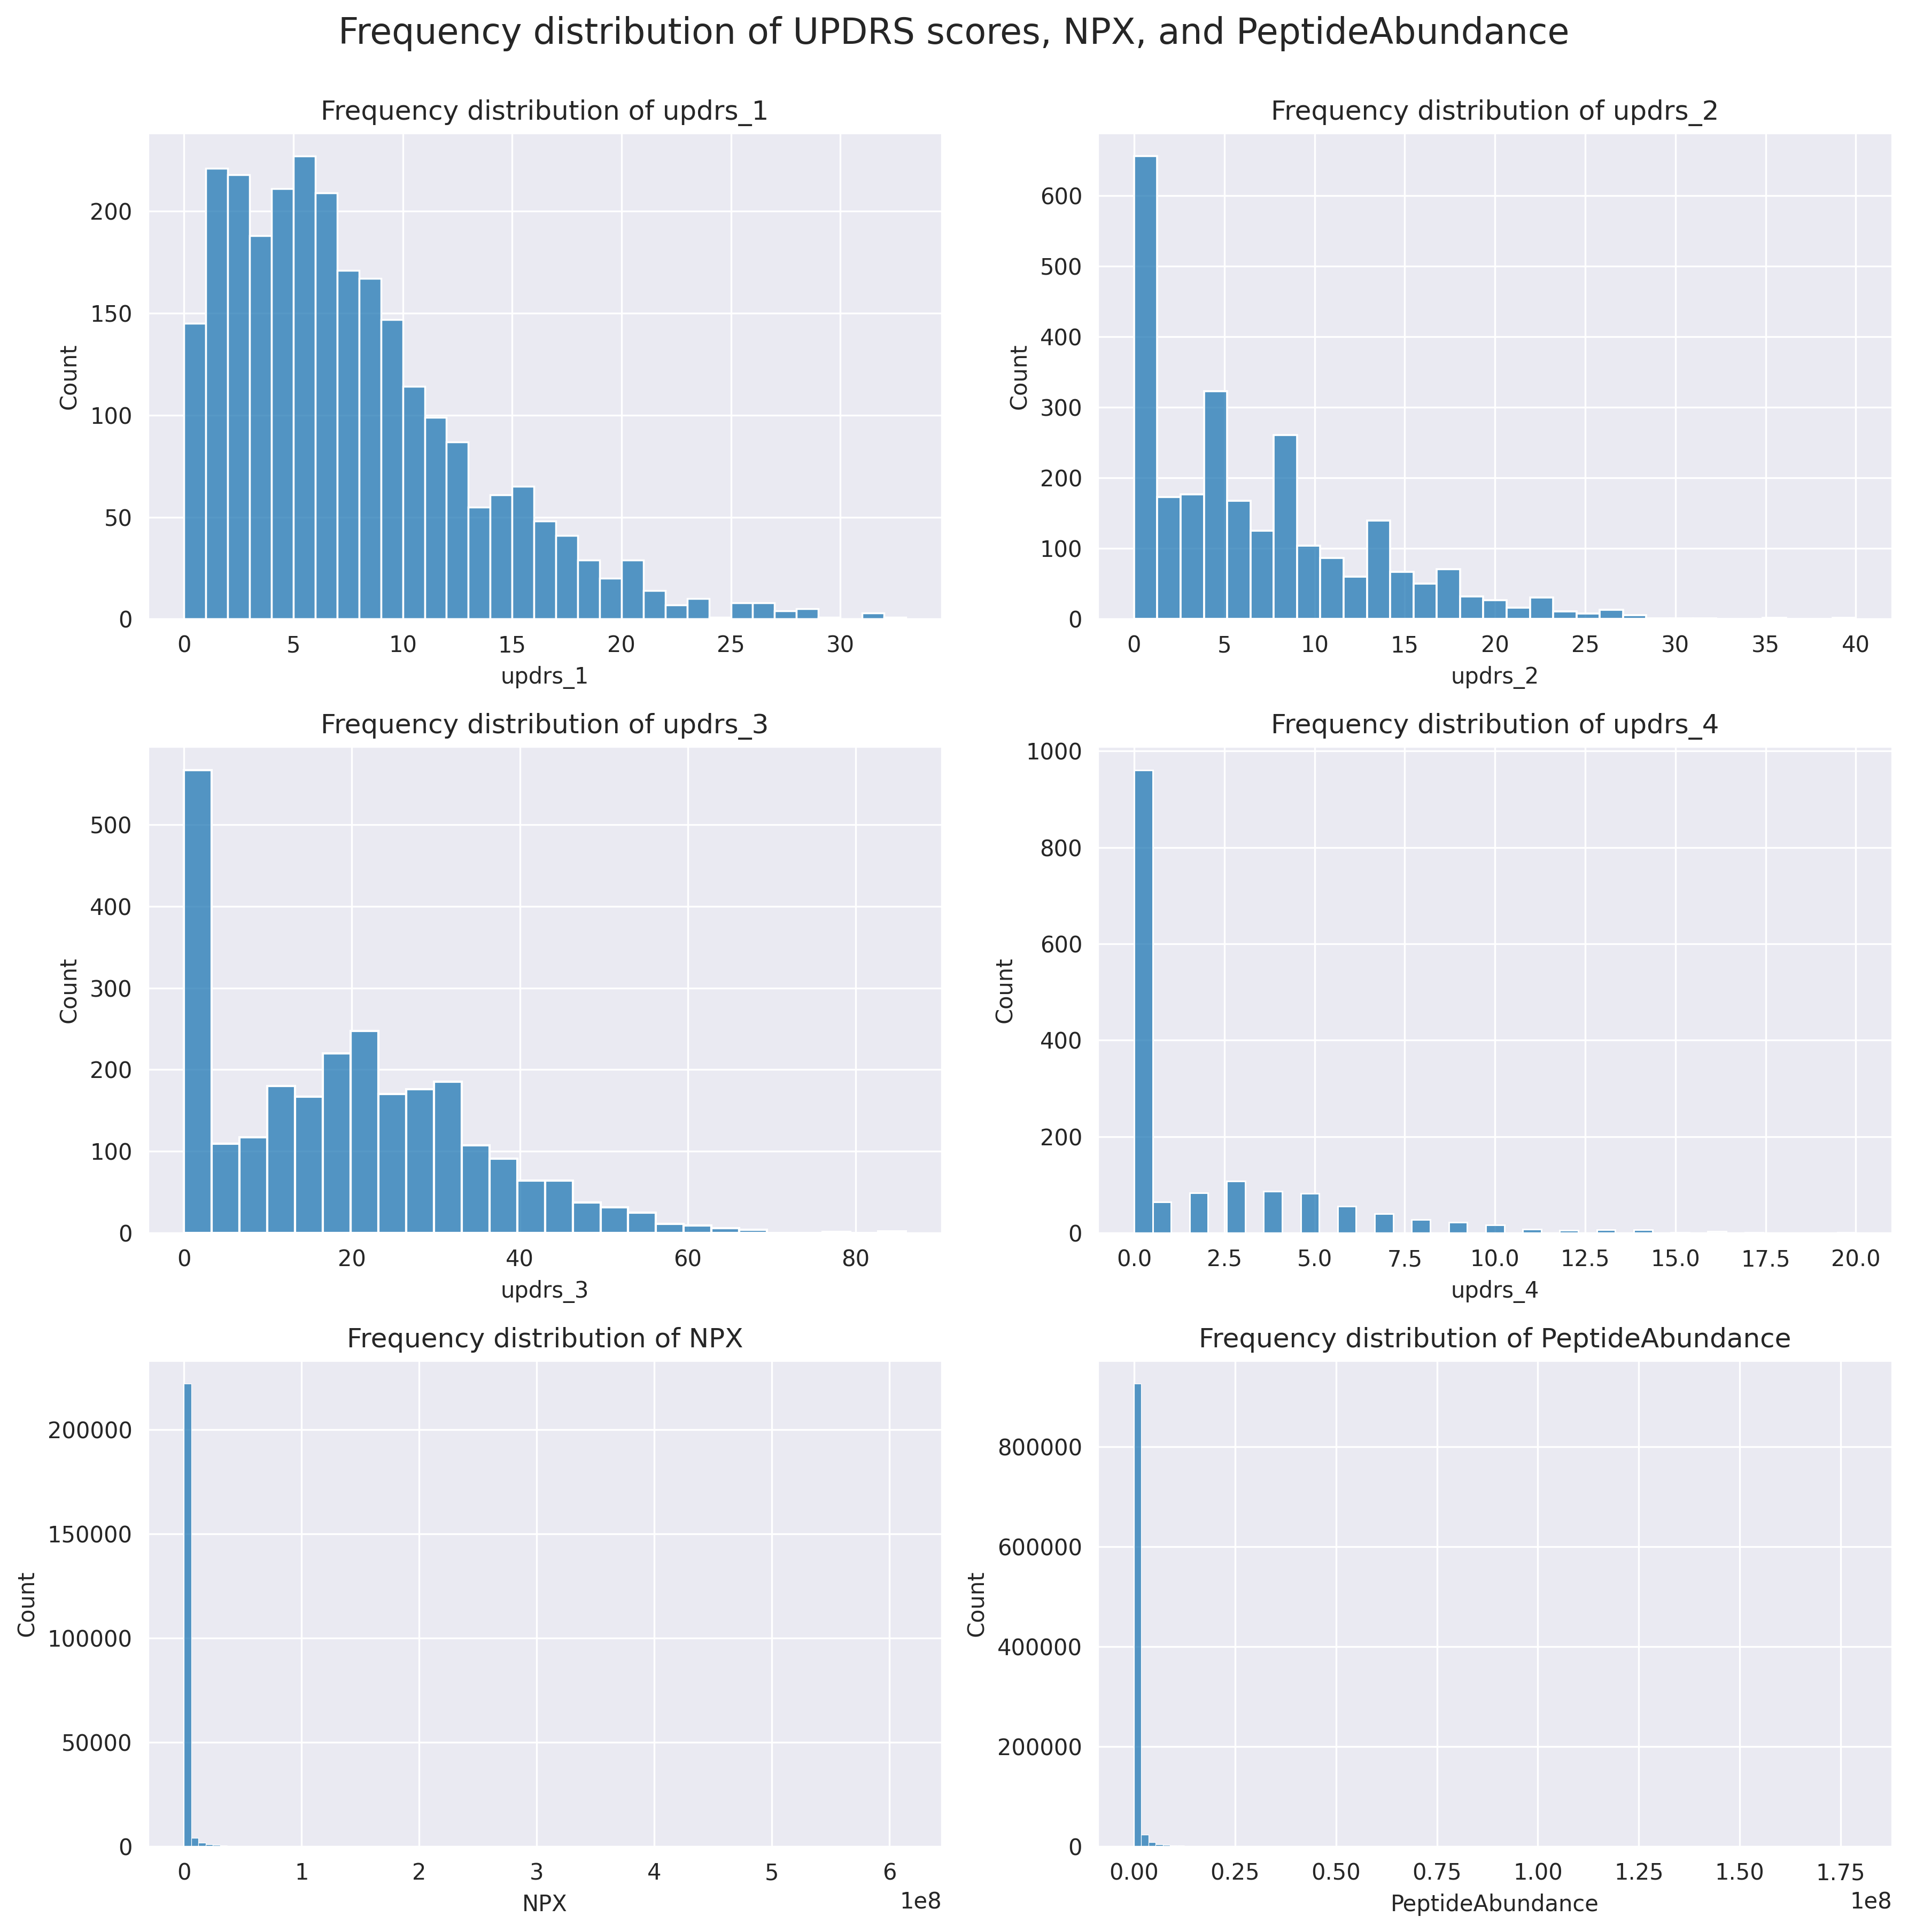

In [15]:
figure, axes = plt.subplots(3, 2, figsize=(12, 12), dpi=300)

for index in range(4):

    column_name = f"updrs_{index + 1}"

    sns.histplot(clinical_data_df[column_name], ax=axes[index // 2, index % 2])
    axes[index // 2, index % 2].set_title(f"Frequency distribution of {column_name}")



sns.histplot(proteins_df["NPX"], ax=axes[2, 0], bins=100)
axes[2, 0].set_title("Frequency distribution of NPX")

sns.histplot(peptides_df["PeptideAbundance"], ax=axes[2, 1], bins=100)
axes[2, 1].set_title("Frequency distribution of PeptideAbundance")

figure.suptitle("Frequency distribution of UPDRS scores, NPX, and PeptideAbundance", fontsize=16, y=1)
figure.tight_layout()


From the above plots, all four `updrs` columns appear to be skewed to the right. This is understandable because as parkinson's disease progresses, the `updrs` values will increase and the patient will have more severe symptoms of parkinson's disease. And because parkinson's has no cure, the number of patients with severe symptoms will be less than the number of patients with mild symptoms.

Also, it seems that there is a lot of variance between the values of both `NPX` and `PeptideAbundance` columns. Let's try to see if using a log scale will help us see the distribution better.

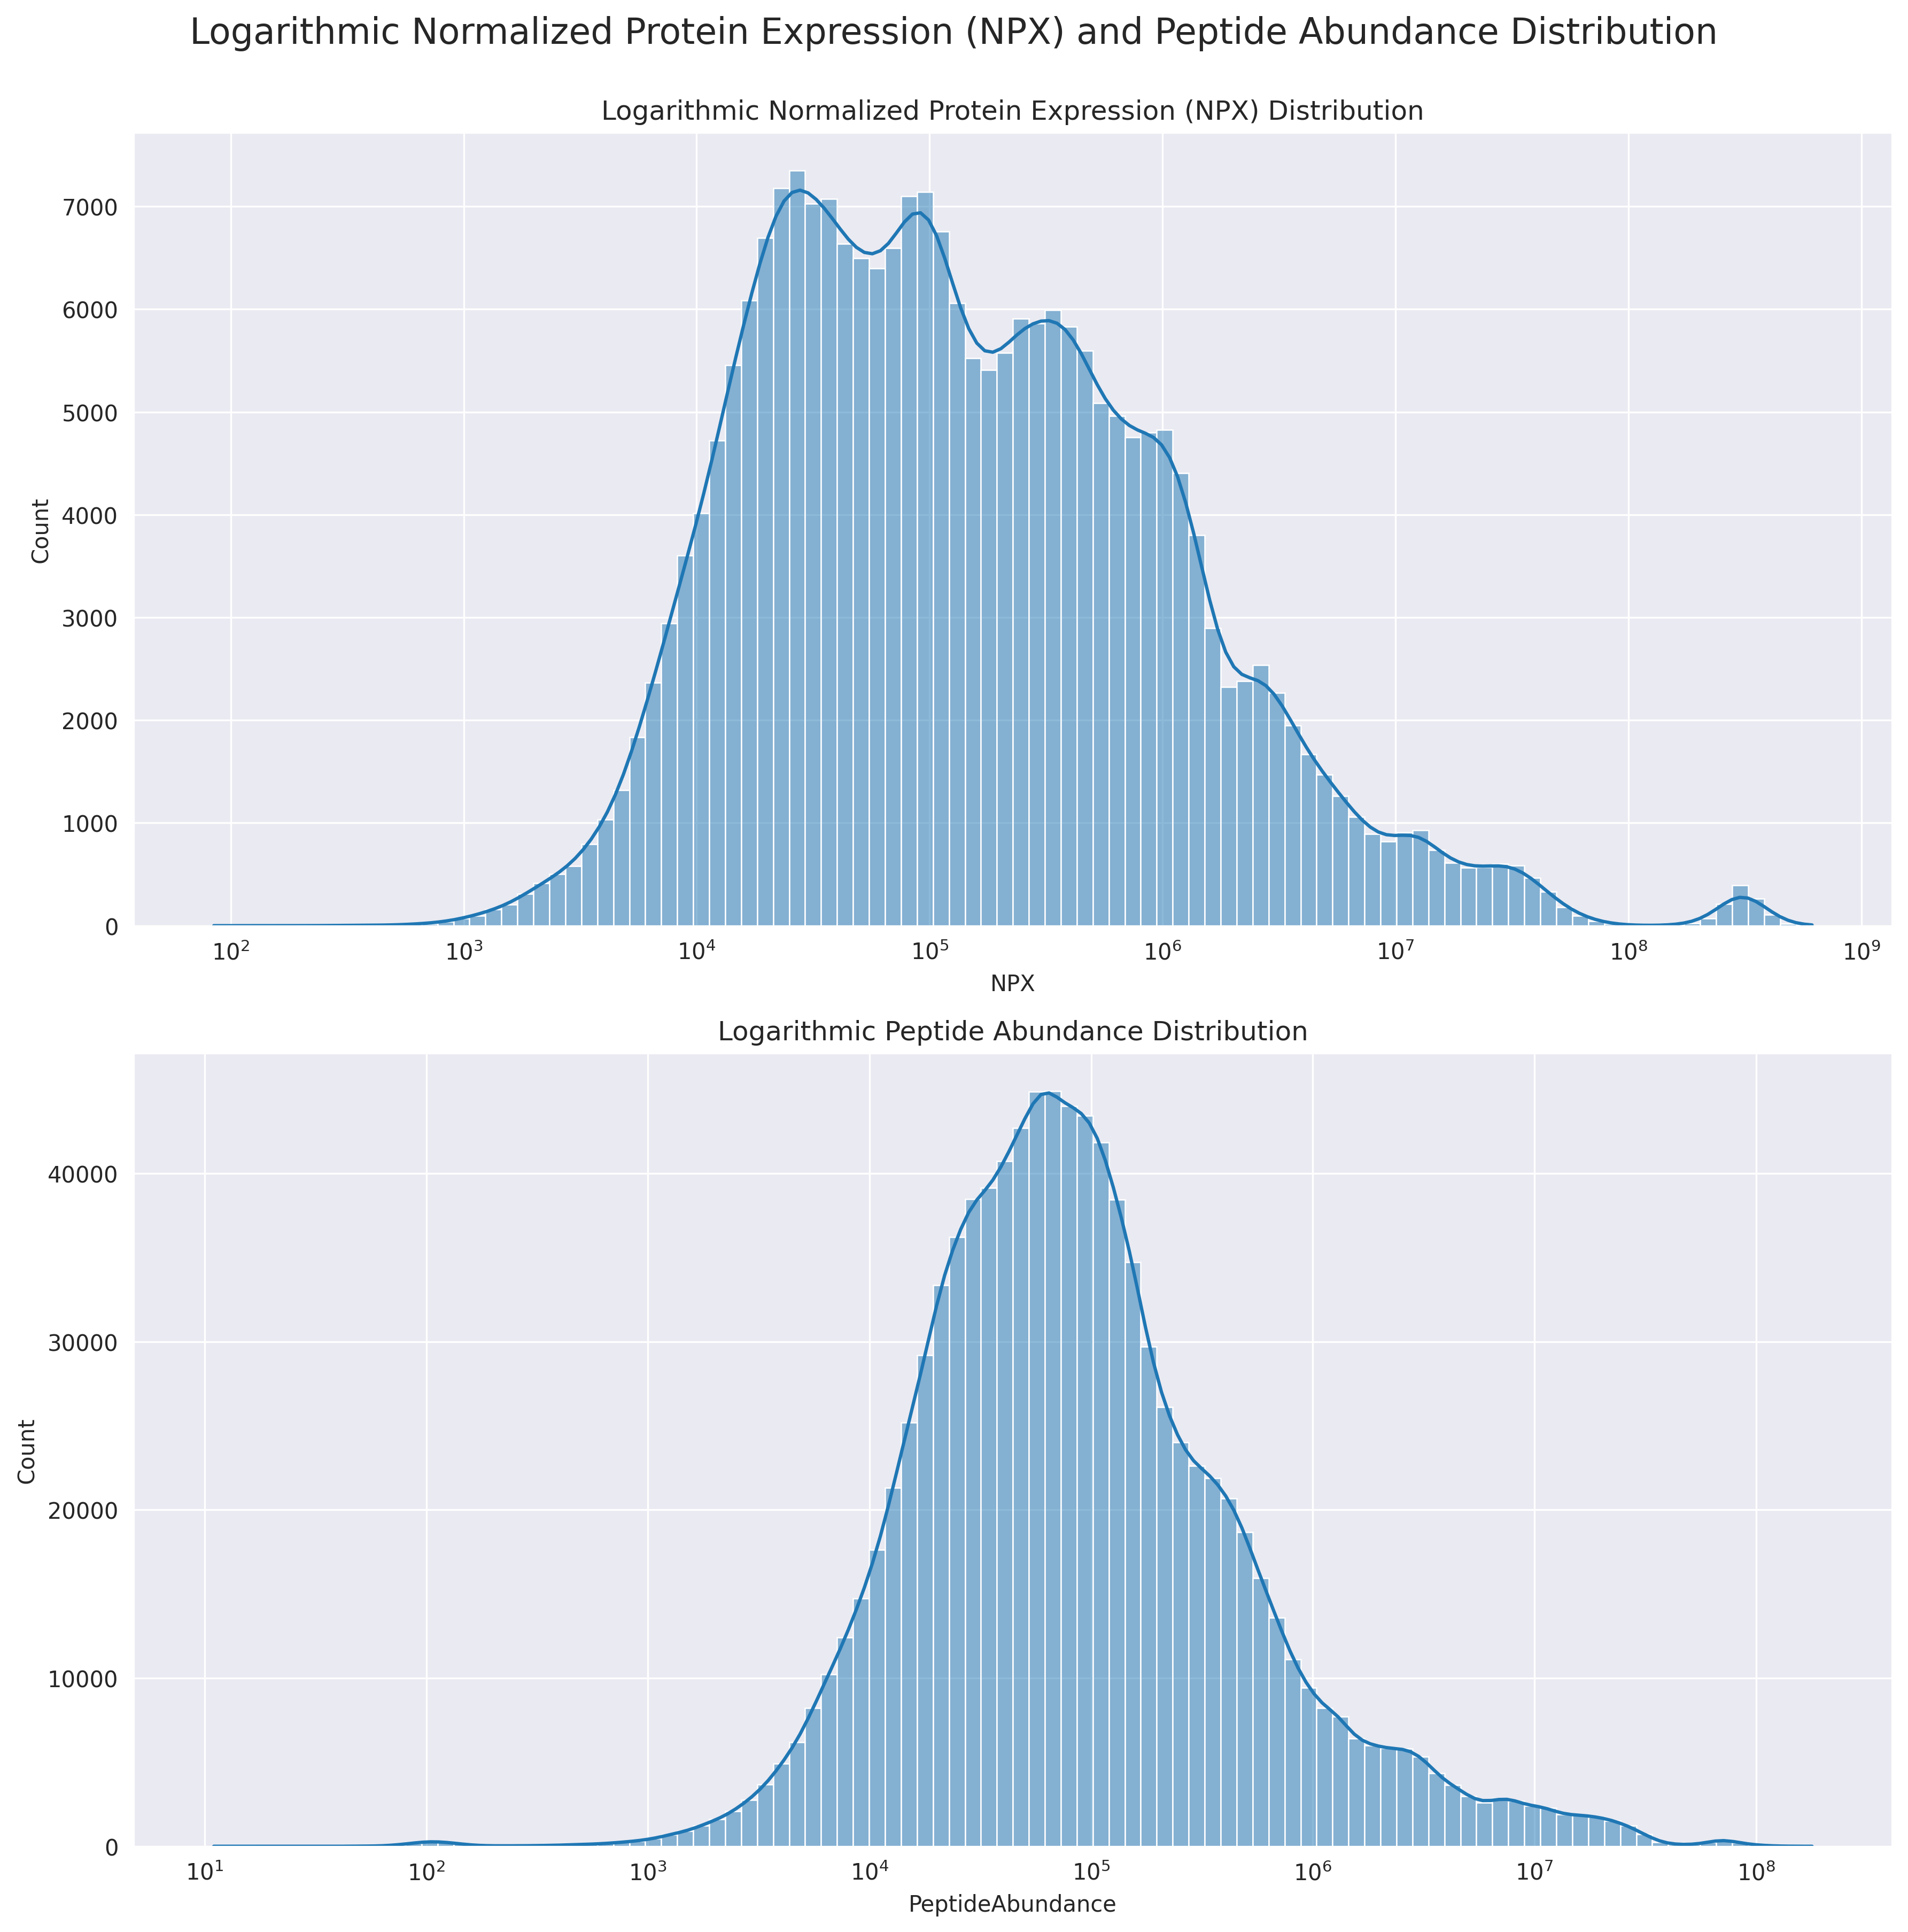

In [16]:
figure, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 12), dpi=300)

sns.histplot(proteins_df["NPX"], log_scale=True, kde=True, bins=100, ax=axes[0])
axes[0].set_title("Logarithmic Normalized Protein Expression (NPX) Distribution")

sns.histplot(peptides_df["PeptideAbundance"], log_scale=True, kde=True, bins=100, ax=axes[1])
axes[1].set_title("Logarithmic Peptide Abundance Distribution")

figure.suptitle("Logarithmic Normalized Protein Expression (NPX) and Peptide Abundance Distribution", fontsize=16, y=1)
figure.tight_layout()
plt.show()

As we can see from the above graph, it will be prudent to use a log scale for both `NPX` and `PeptideAbundance` columns as both these columns span multiple orders of magnitude. However, we will have to be careful while using the log scale because both `NPX` and `PeptideAbundance` columns have a lot of missing values.


On a side note, if the `updrs` values are going to be used as features, it will also be interesting to see if transforming the `updrs` values to a log scale will help improve the model.

### 2.2 Exploring correlations

#### 2.2.1 Correlation between columns in `train_clinical_data.csv`

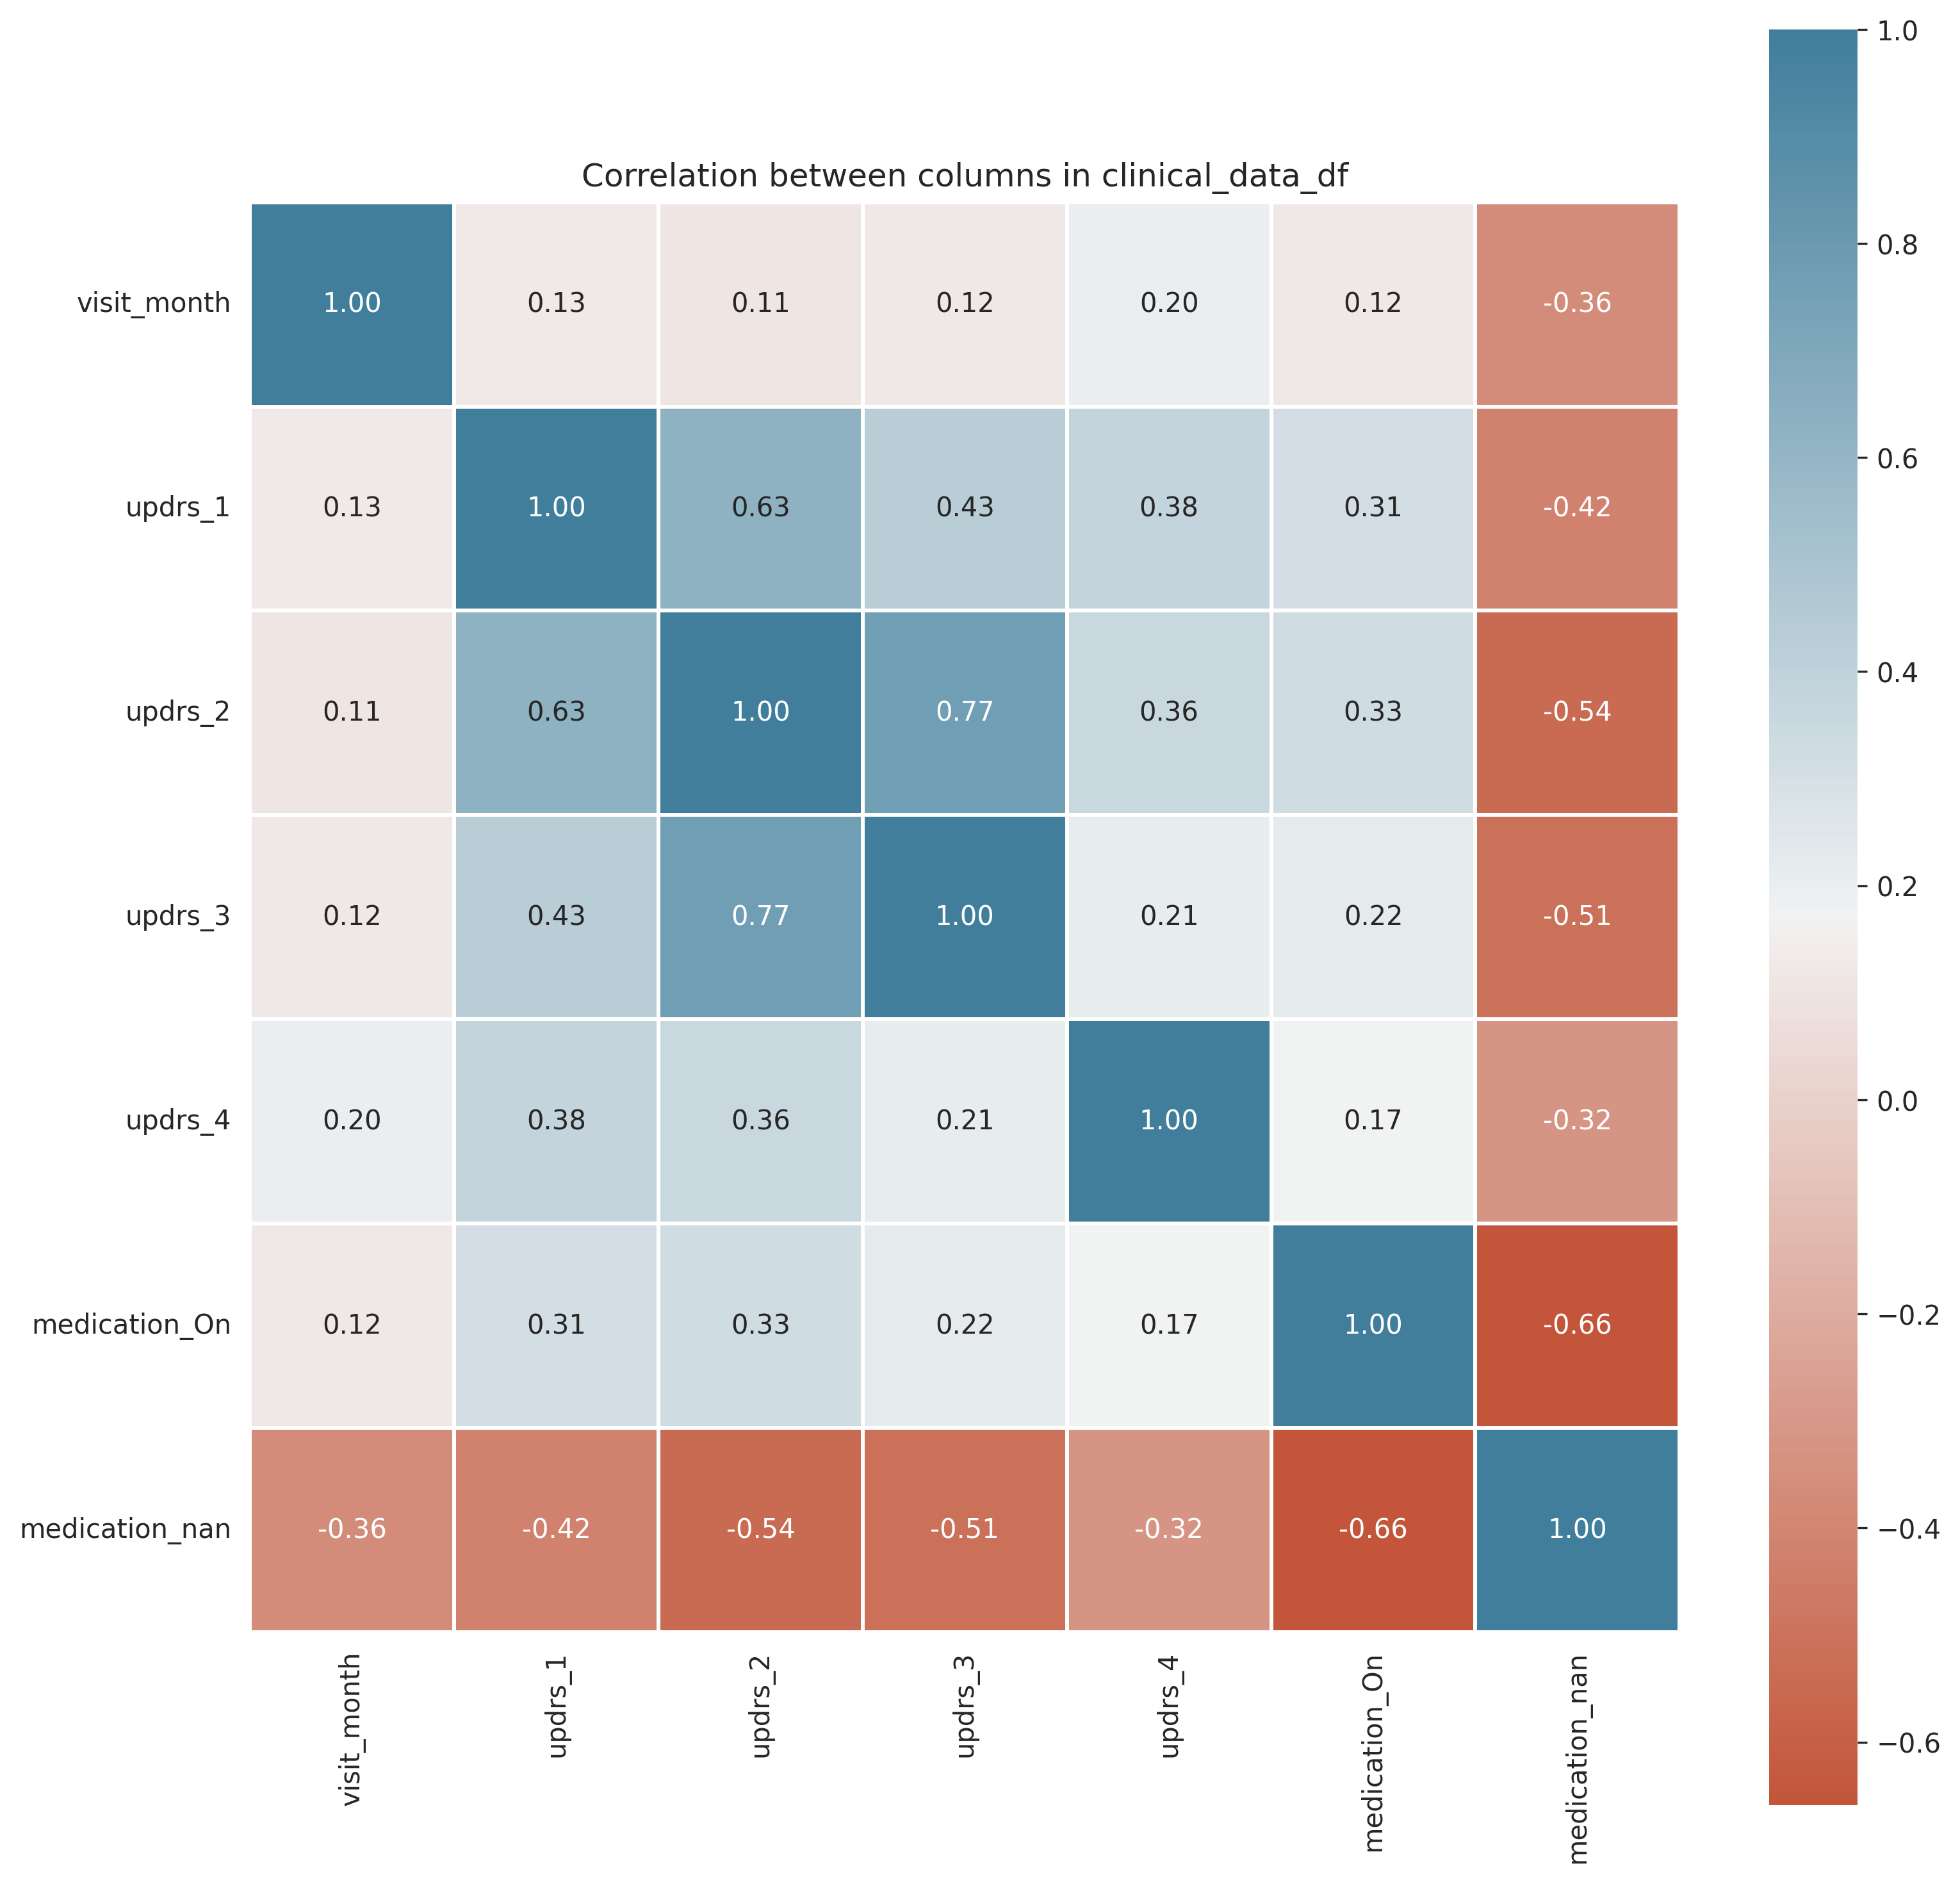

In [17]:
# Is there any correlation between the columns in the clinical_data_df?

plt.figure(figsize=(12, 12), dpi=300)
sns.heatmap(clinical_data_df.iloc[:, 1:].corr(method="spearman"), cmap=sns.diverging_palette(230, 20, as_cmap=True).reversed(), annot=True, fmt=".2f", square=True, linewidths=1)
plt.title("Correlation between columns in clinical_data_df")
plt.show()


#### 2.2.2 Auto-correlation of `updrs` values with its previous values.

From the above heatmap, it seems that there is a strong correlation between `updrs_1` and `updrs_2` columns. This is understandable because both these columns are related to the motor and non-motor aspects of experiences of daily living. Also, there is a strong correlation between `updrs_3` and `updrs_2` columns. This is also understandable because `updrs_2` is related to the motor aspects of experiences of daily living and `updrs_3` is related to the motor examination. 

On a side note, `medication` also seems to infulence the `updrs` values. What's more interesting the `visit_month` has a weak positive correlation with all the `updrs` columns. One possible explanation for this could be that as the disease progresses, the `updrs` values increase however, it does not seem to always be the case here because the correlation is very weak.

In [18]:
# Is there any correlation along the time dimension?

# Create an empty DataFrame to store autocorrelation results for each patient
autocorrelations = {
    "patient_id": [],
    "column": [],
    "lag": [],
    "autocorrelation": [],
}

# groups = clinical_data_df.groupby(level=0)
groups = clinical_data_df.groupby("patient_id")

for patient_id, group in groups:

    for col in ["updrs_1", "updrs_2", "updrs_3", "updrs_4"]:

        for lag in [1,2,3]:

            # Check if there are at least two non-NaN values and if the variance is greater than 0
            if group[col].count() > lag+1 and group[col].var() > 0:
                # Calculate autocorrelation with a lag of 1 (previous value)
                autocorrelation = group[col].autocorr(lag=lag)
            else:
                autocorrelation = None


            autocorrelations['patient_id'].append(patient_id)
            autocorrelations['column'].append(col)
            autocorrelations['lag'].append(lag)
            autocorrelations['autocorrelation'].append(autocorrelation)

# Convert autocorrelations dictionary to a DataFrame
autocorrelations = pd.DataFrame(autocorrelations)


# Create a bar plot for each column in the autocorrelations DataFrame
# Note: Uncomment the following line to see the data for multiple lags
# figure, axes = plt.subplots(nrows=4, ncols=1, figsize=(30, 15), dpi=600)
figure, axes = plt.subplots(nrows=4, ncols=1, figsize=(12, 15), dpi=600)

# Iterate through each unique column in the autocorrelations DataFrame
for index, col in enumerate(autocorrelations['column'].unique()):

    # Note: Uncomment the following line to see the data for multiple lags
    # for lag in [1, 2, 3]:
    for lag in [1]:

        # Filter autocorrelations DataFrame to get data for the current column
        col_autocorrelations = autocorrelations[
            (autocorrelations["column"] == col) & (autocorrelations["lag"] == lag)
        ]

        # Note: Uncomment the following line to see the data for multiple lags
        # ax = axes[index, lag - 1]
        ax = axes[index]
        
        # Create a bar plot using Seaborn

        sns.barplot(x='patient_id', y='autocorrelation', data=col_autocorrelations, ax=ax, palette="Blues_d")
        
        # Set plot title and axis labels
        ax.set_title(f'{col} (lag={lag})')
        ax.set_xlabel('Patient IDs')
        ax.set_ylabel('Autocorrelation')
        ax.set_xticks([])
    

figure.suptitle("Autocorrelation for UPDRS scores", fontsize=16, y=1)
figure.tight_layout()

# Show the plot
plt.show()



From the above plots, there seems to be some strong correlations between each of the UPDRS scores with past values of itself for each patient. This pattern repeats for other increasing lag values as well (Note: Uncomment the code sections to display graph for all three lag values). This is understandable because as the disease progresses, the UPDRS scores will increase.


This combined with the correlation matrix from [Section 2.2.1 Correlation between columns in `train_clinical_data.csv`](#2.2.1-Correlation-between-columns-in-`train_clinical_data.csv`) suggests that the `updrs` values for each patient are correlated with each other and also auto-correlated with its past values of itself. This is a good thing because it means that we can use the past values of `updrs` to predict the future values of `updrs` for each patient.

### 2.2.3 Investigating whether the value of UPDRS increase or decrease with each visit

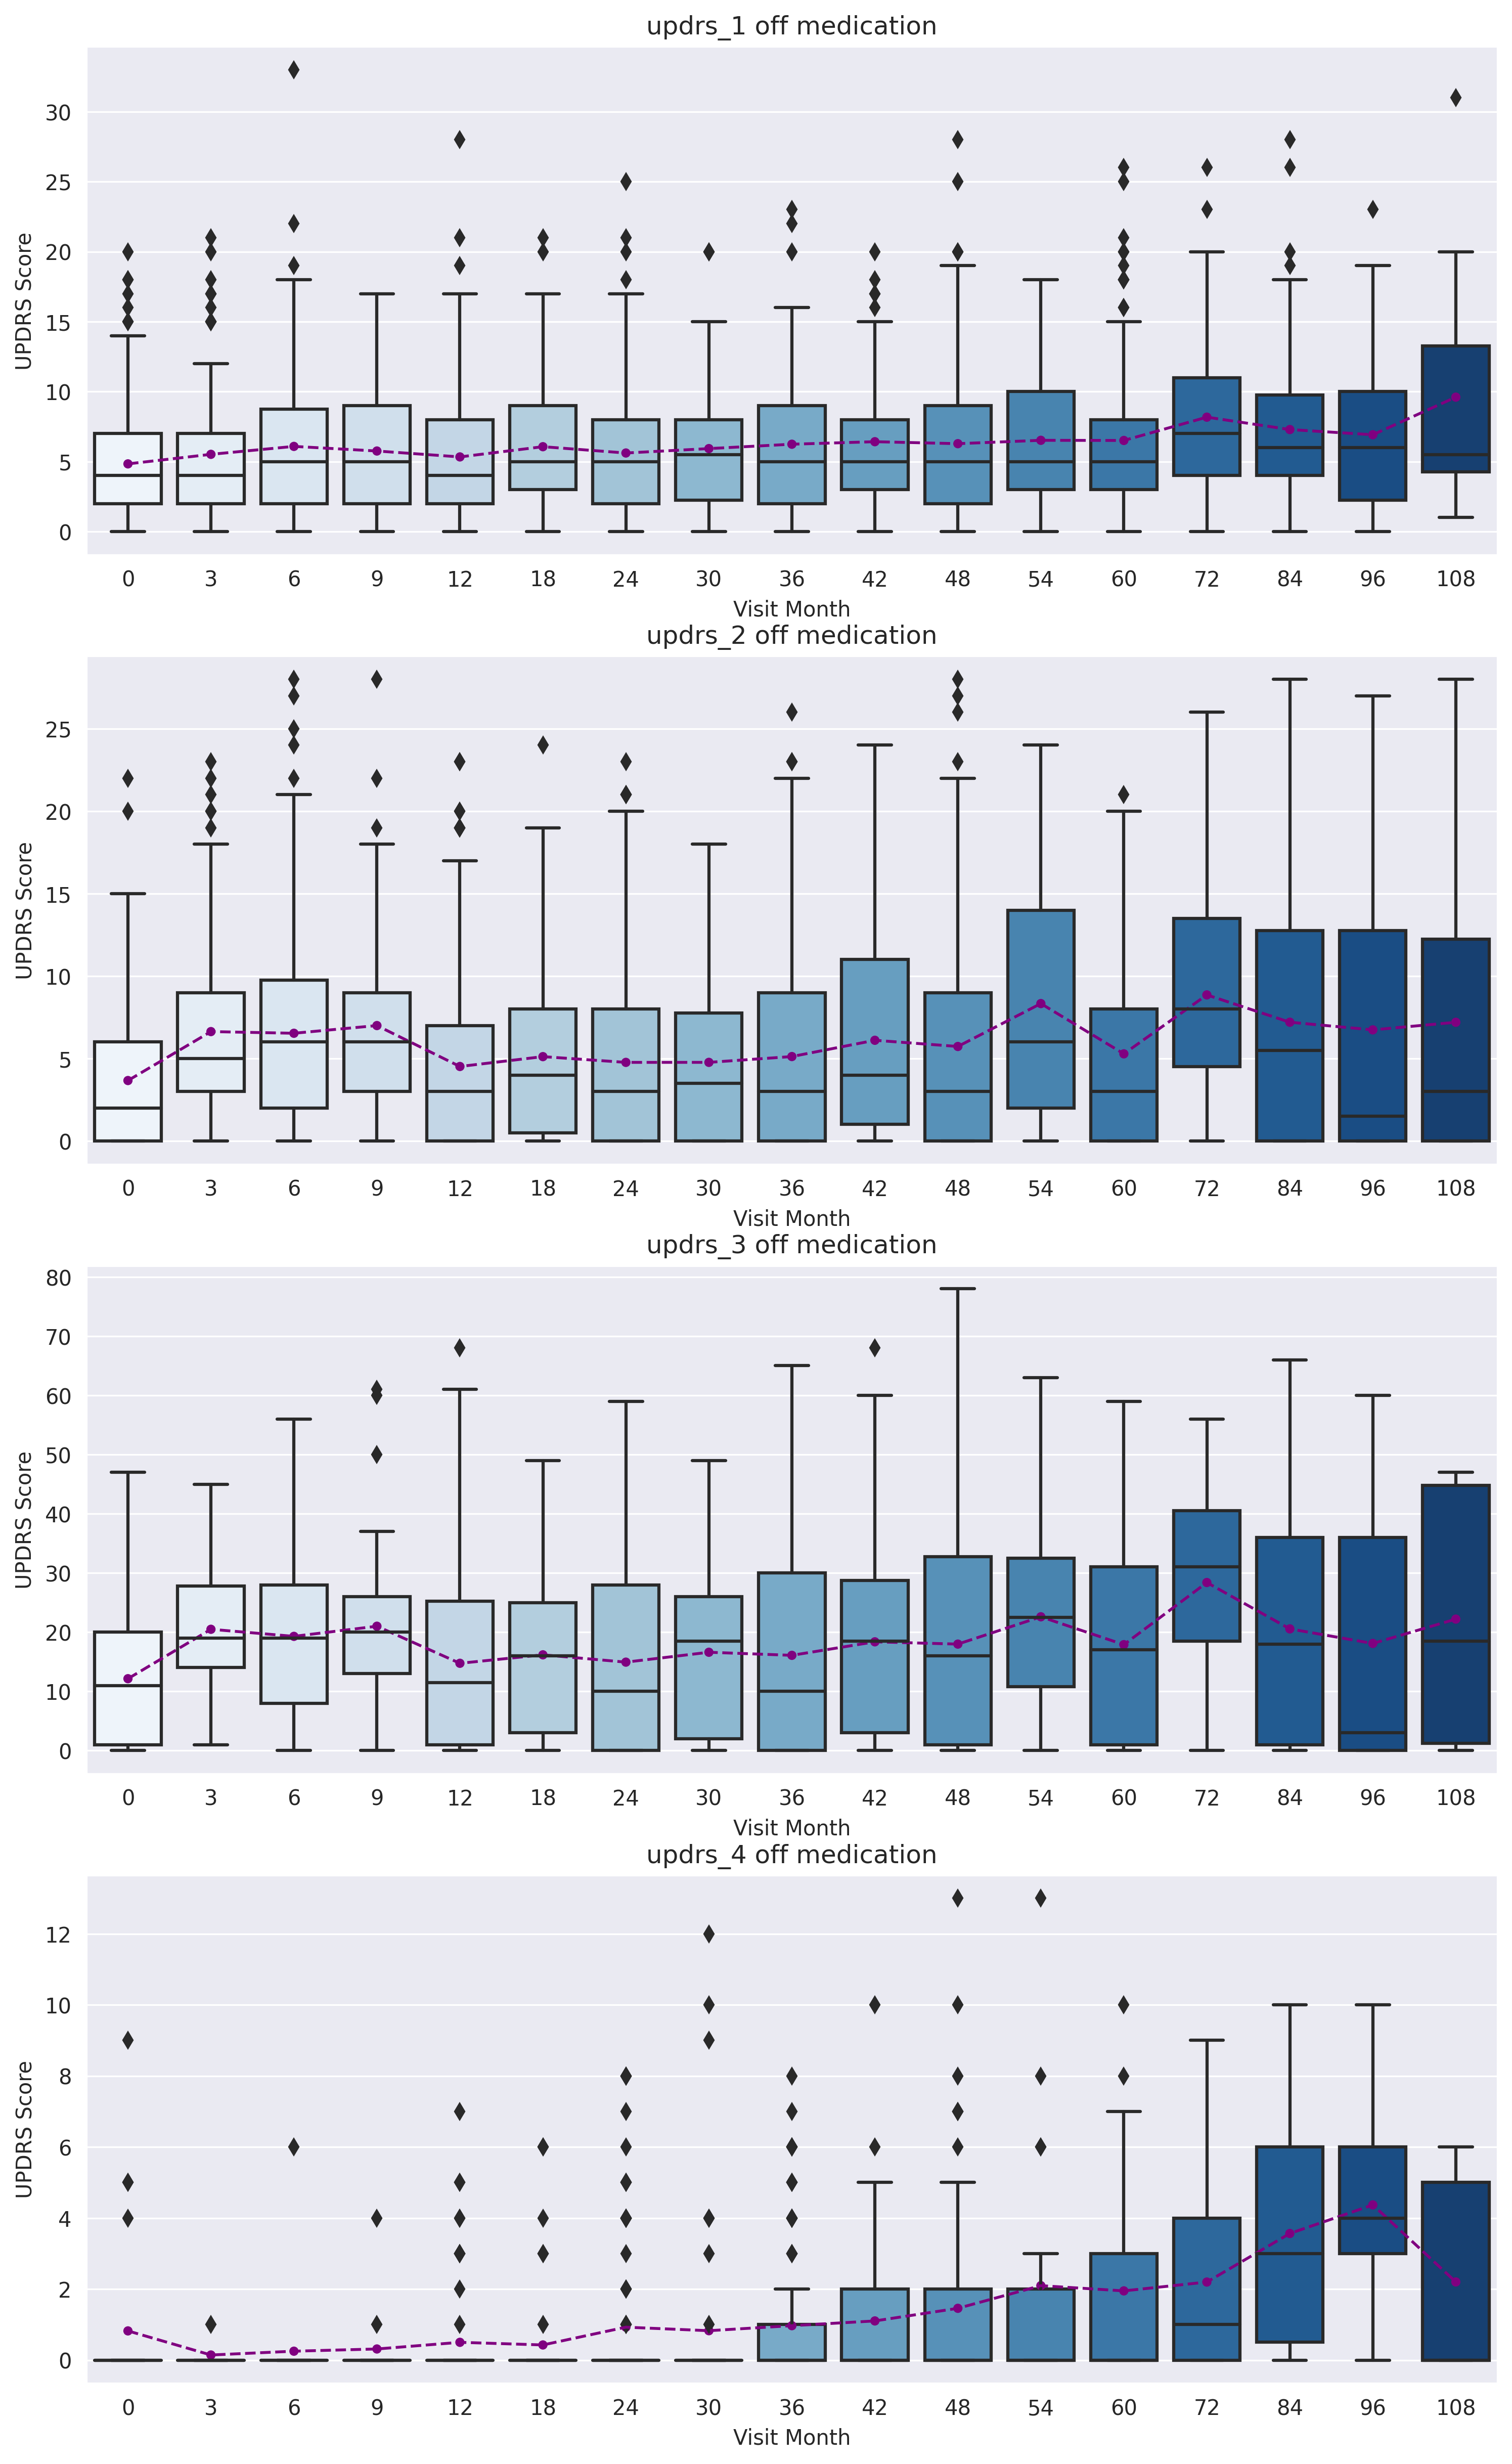

In [19]:
# Off medication

figure, axes = plt.subplots(nrows=4, ncols=1, figsize=(12, 20), dpi=300)

# Iterate through each unique column in the clinical_data_df DataFrame
for index, col in enumerate(["updrs_1", "updrs_2", "updrs_3", "updrs_4"]):

    data = clinical_data_df[clinical_data_df["medication_On"] == 0]

    # Create a box plot using Seaborn
    sns.boxplot(x="visit_month", y=col, data=data, ax=axes[index], palette="Blues")
    sns.pointplot(x="visit_month", y=col, data=data, ax=axes[index], color="purple", errorbar=None, linestyles="--", scale=.5)

    # Set plot title and axis labels
    axes[index].set_title(f"{col} off medication")
    axes[index].set_xlabel("Visit Month")
    axes[index].set_ylabel("UPDRS Score")


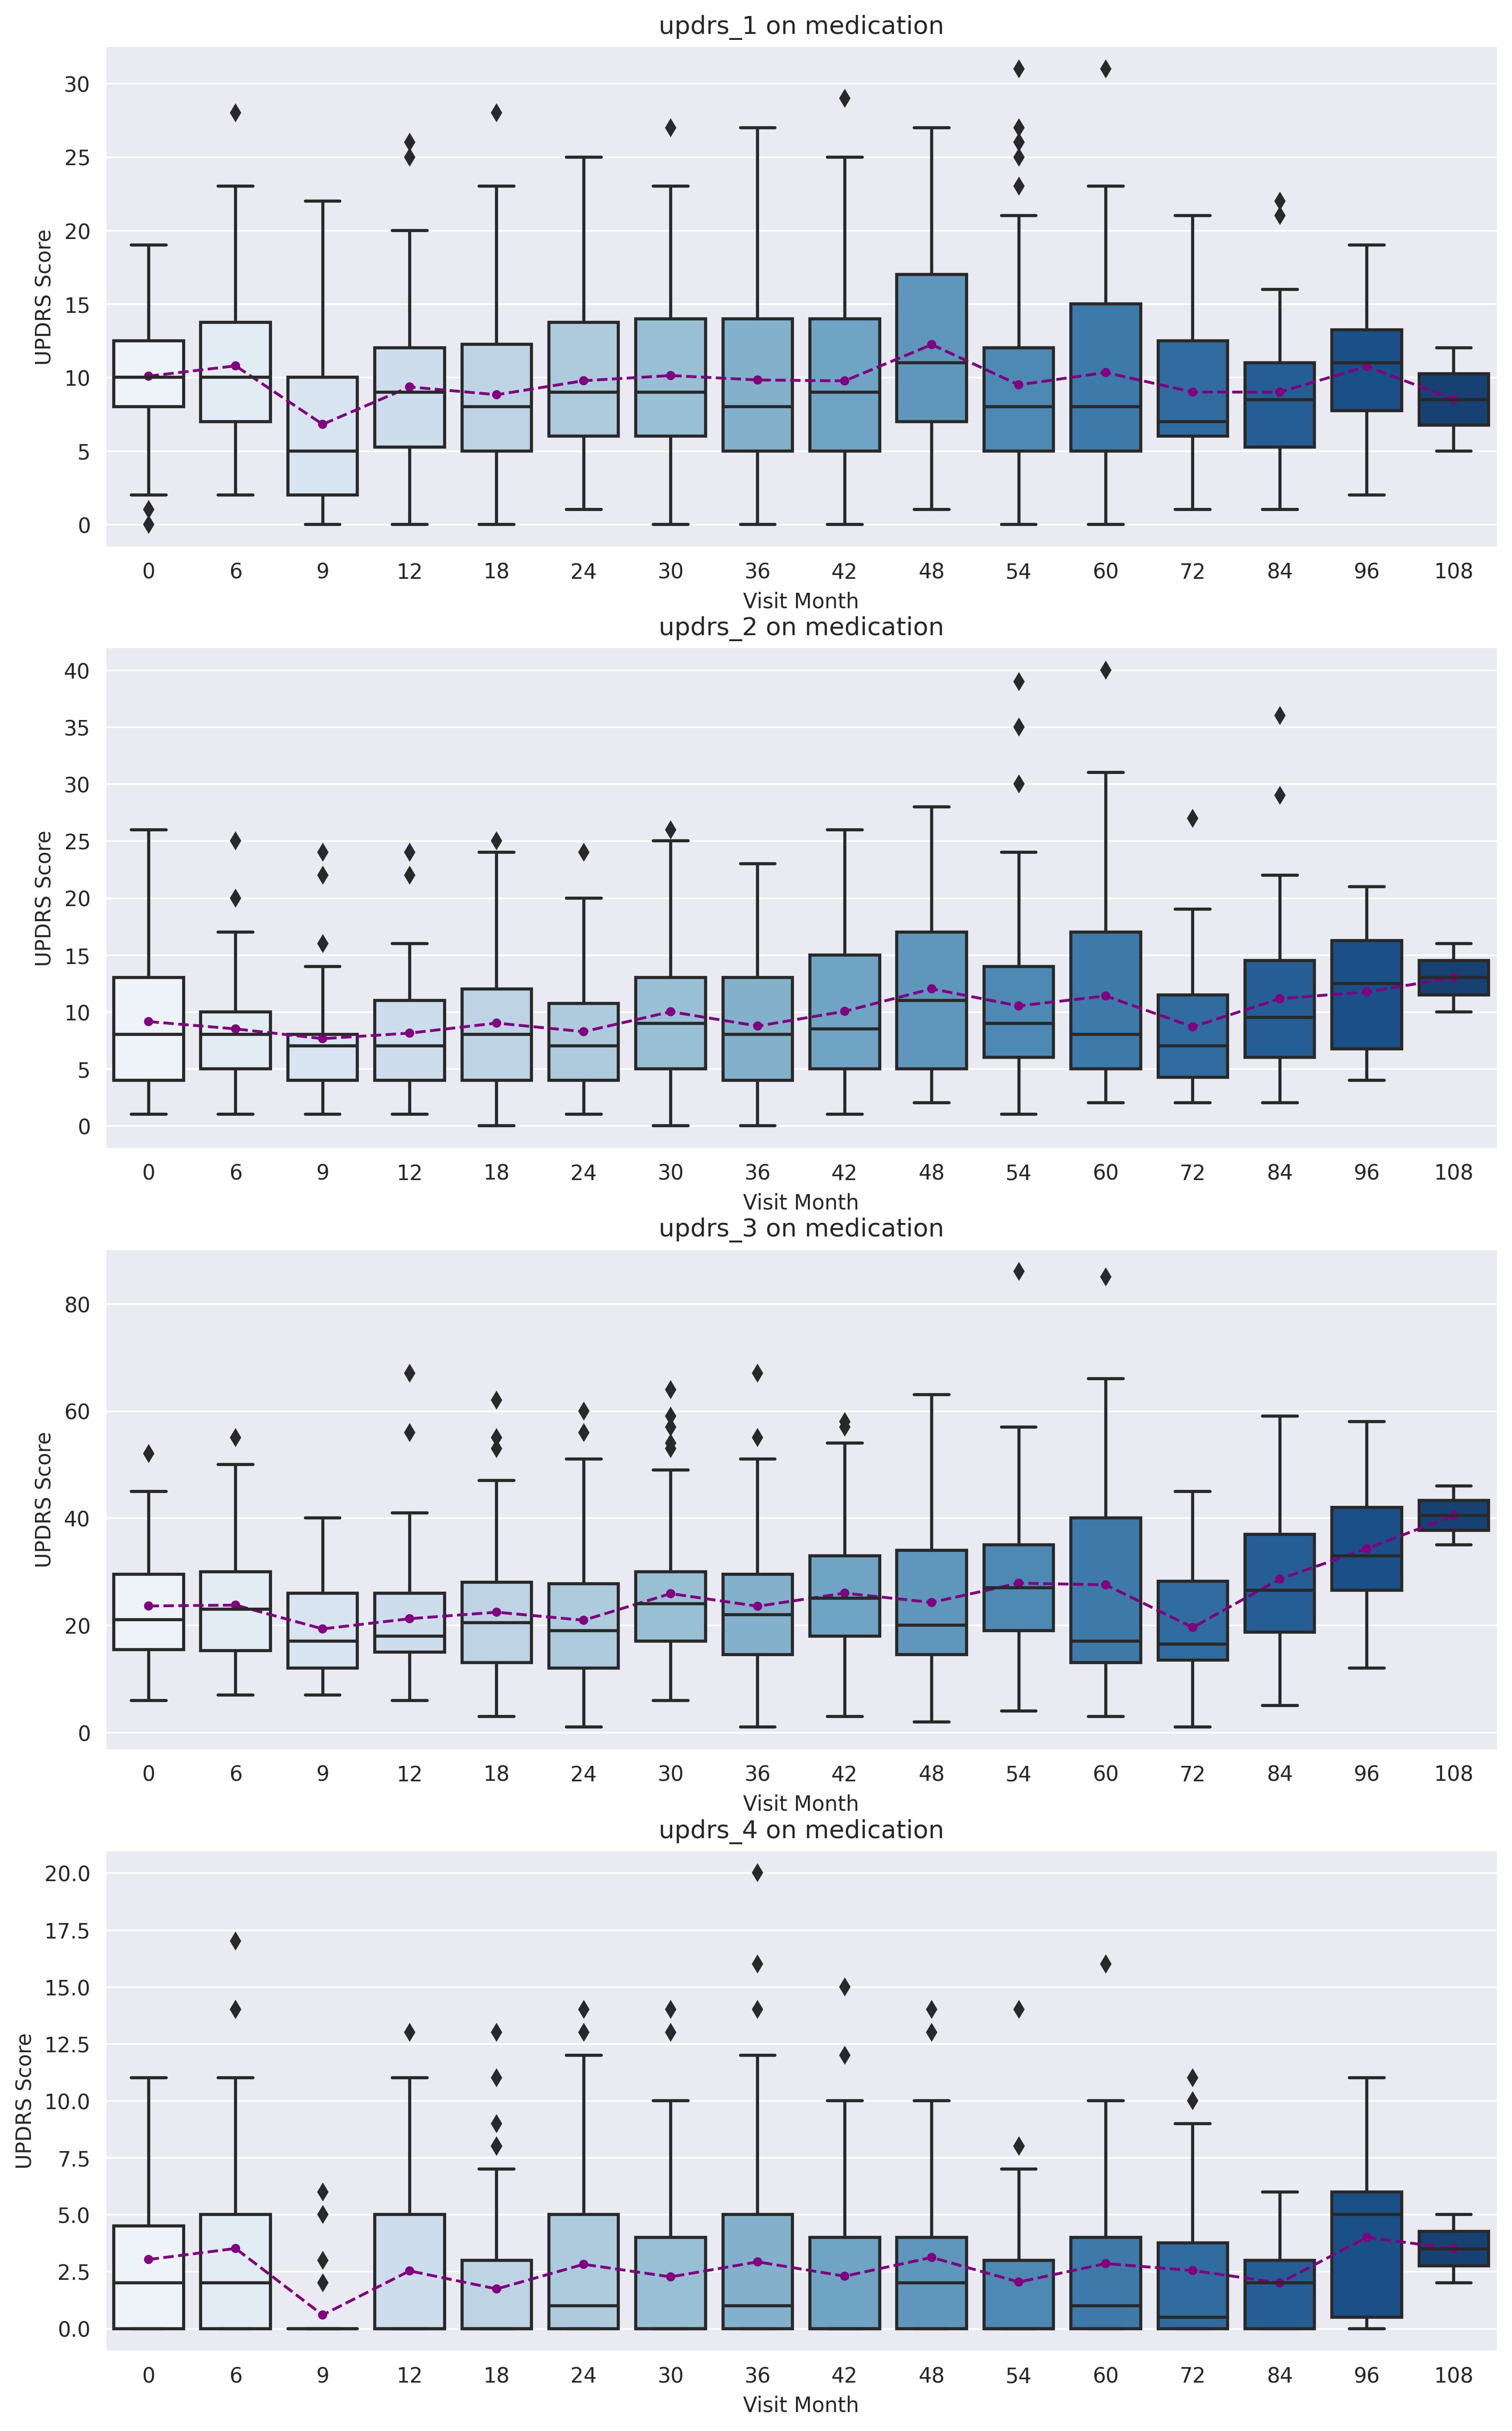

In [20]:
# On medication

figure, axes = plt.subplots(nrows=4, ncols=1, figsize=(12, 20), dpi=300)


# Iterate through each unique column in the clinical_data_df DataFrame
for index, col in enumerate(["updrs_1", "updrs_2", "updrs_3", "updrs_4"]):

    data = clinical_data_df[clinical_data_df["medication_On"] == 1]

    # Create a box plot using Seaborn
    sns.boxplot(x="visit_month", y=col, data=data, ax=axes[index], palette="Blues")
    sns.pointplot(x="visit_month", y=col, data=data, ax=axes[index], color="purple", errorbar=None, linestyles="--", scale=.5)

    # Set plot title and axis labels
    axes[index].set_title(f"{col} on medication")
    axes[index].set_xlabel("Visit Month")
    axes[index].set_ylabel("UPDRS Score")


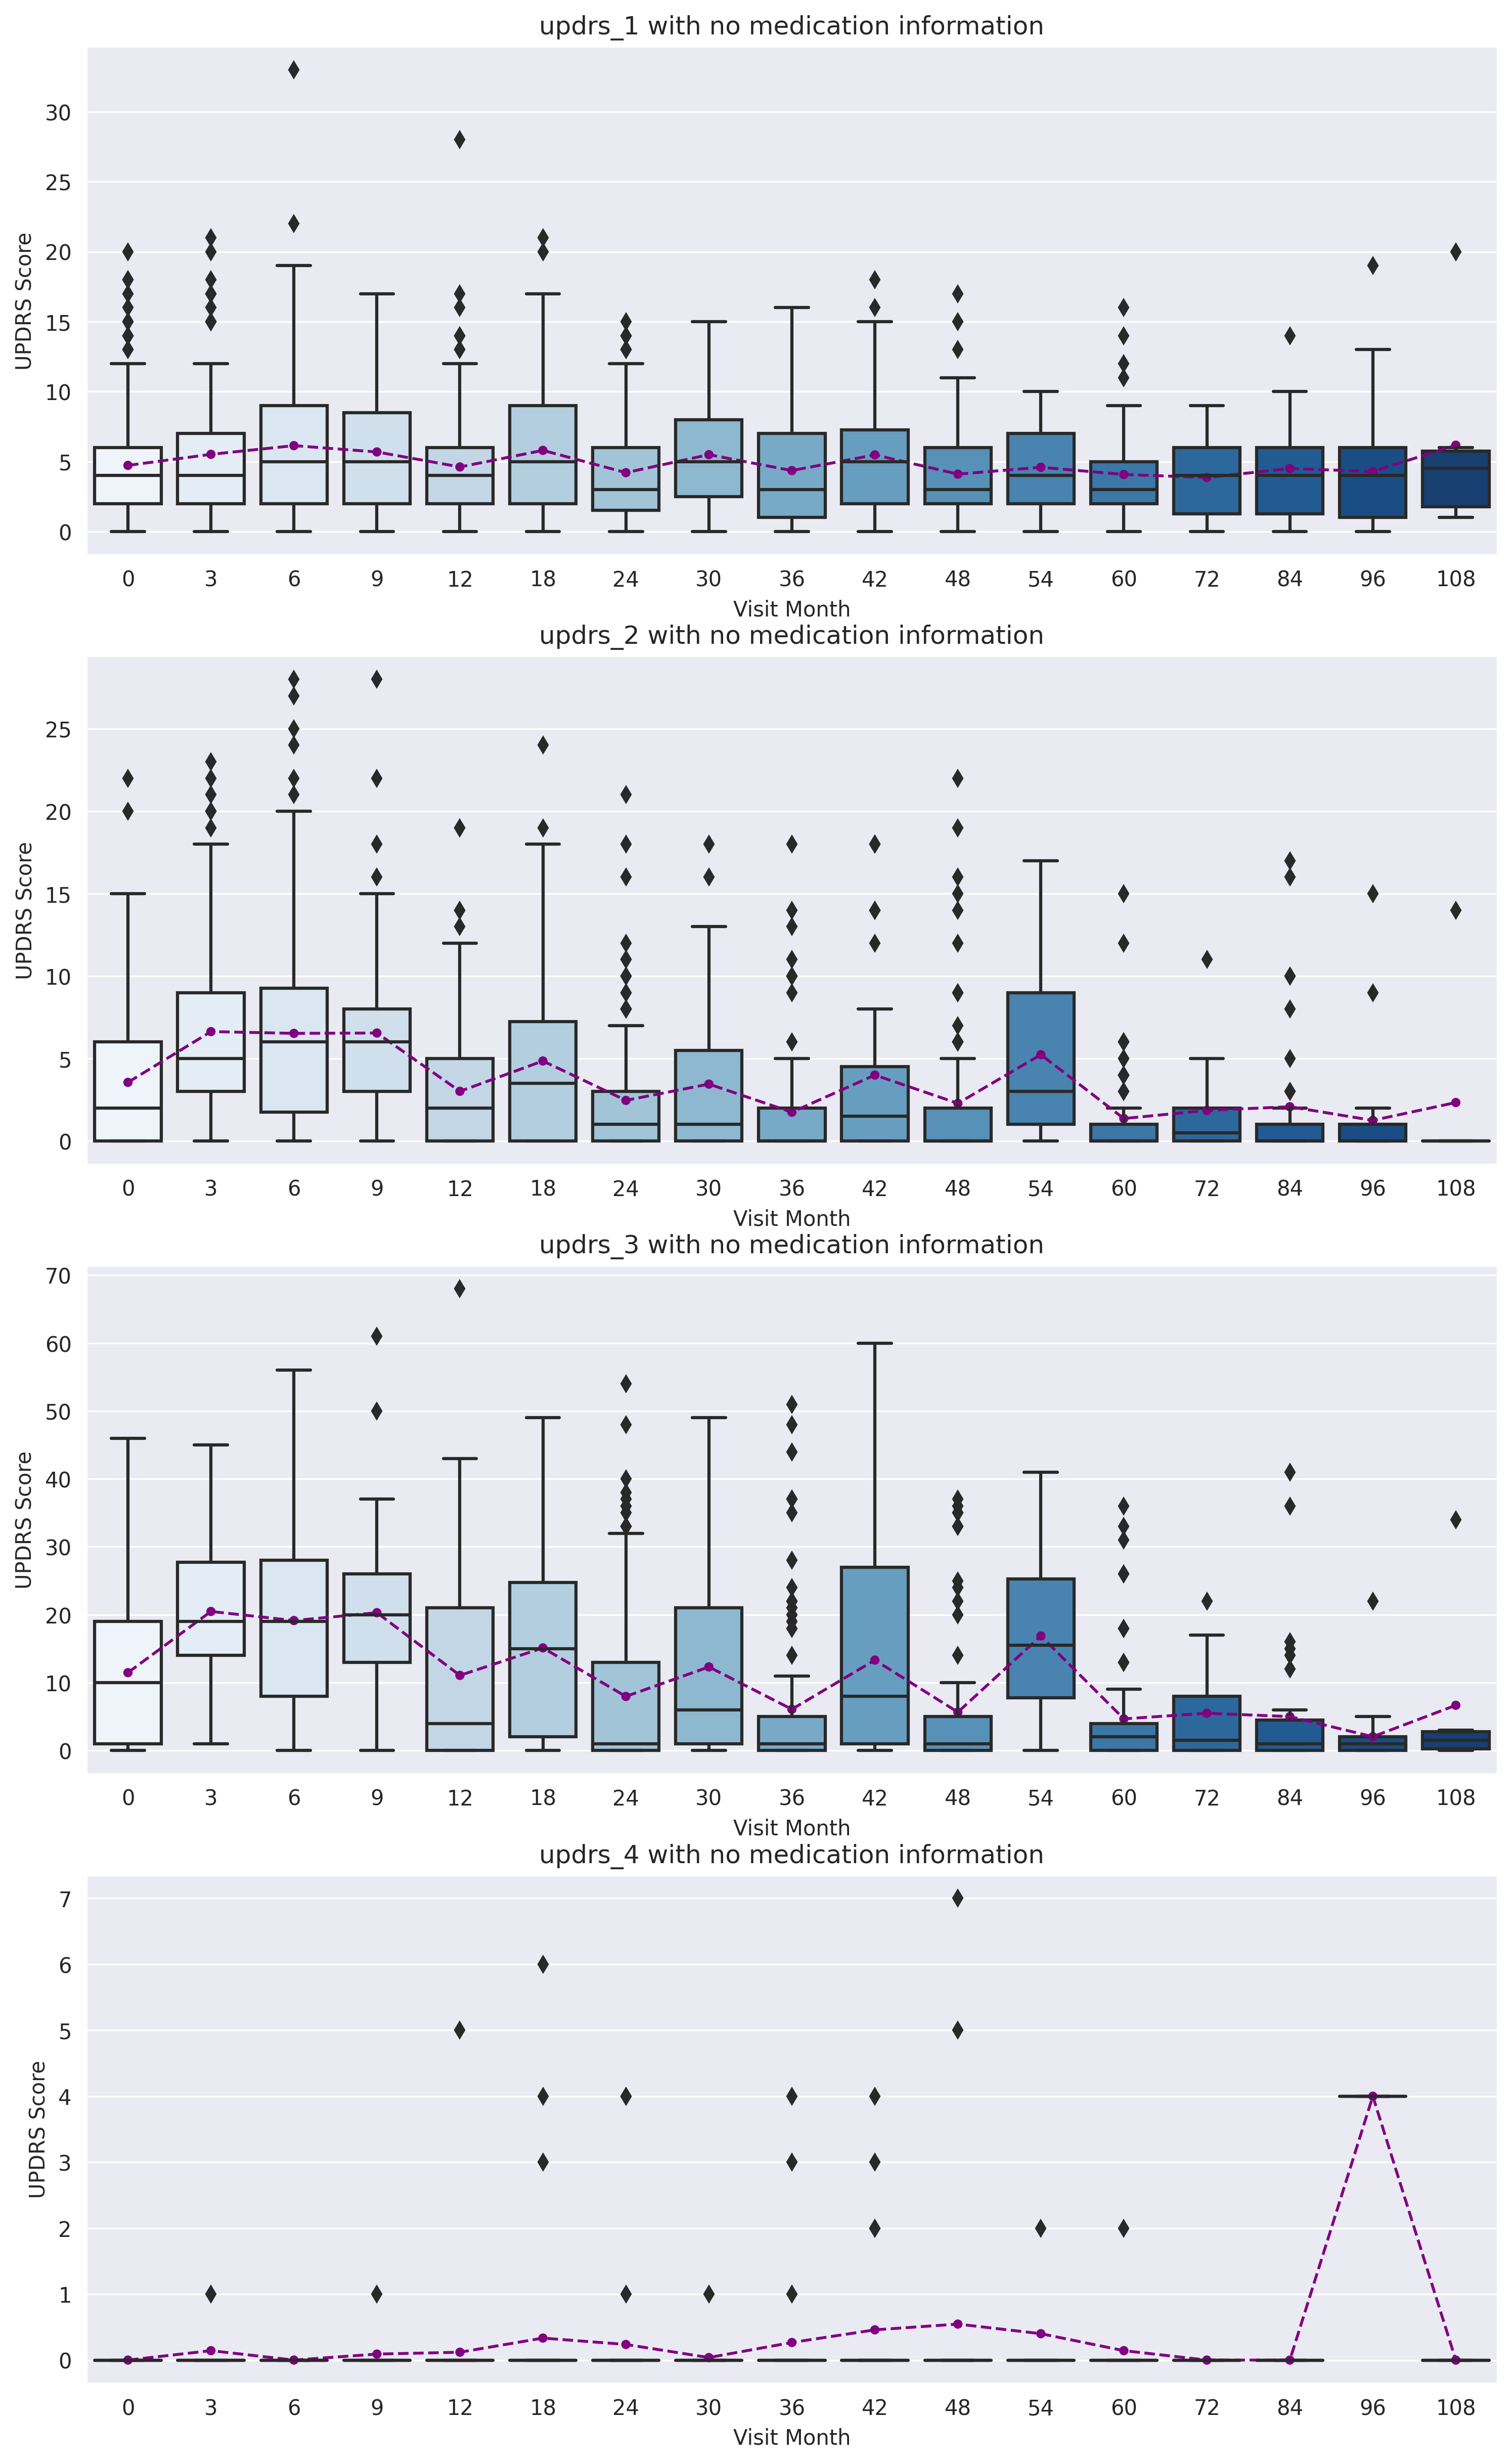

In [21]:
# No Medication data

figure, axes = plt.subplots(nrows=4, ncols=1, figsize=(12, 20), dpi=300)

# Iterate through each unique column in the clinical_data_df DataFrame
for index, col in enumerate(["updrs_1", "updrs_2", "updrs_3", "updrs_4"]):

    data = clinical_data_df[clinical_data_df["medication_nan"] == 1]

    # Create a box plot using Seaborn
    sns.boxplot(x="visit_month", y=col, data=data, ax=axes[index], palette="Blues")
    sns.pointplot(x="visit_month", y=col, data=data, ax=axes[index], color="purple", errorbar=None, linestyles="--", scale=.5)

    # Set plot title and axis labels
    axes[index].set_title(f"{col} with no medication information")
    axes[index].set_xlabel("Visit Month")
    axes[index].set_ylabel("UPDRS Score")


The above graph for `updrs_4` shows a very interesting trend. It seems that the patients with no medication information have a higher possibliity of missing `updrs_4` values.

Text(0, 0.5, 'UPDRS Score')

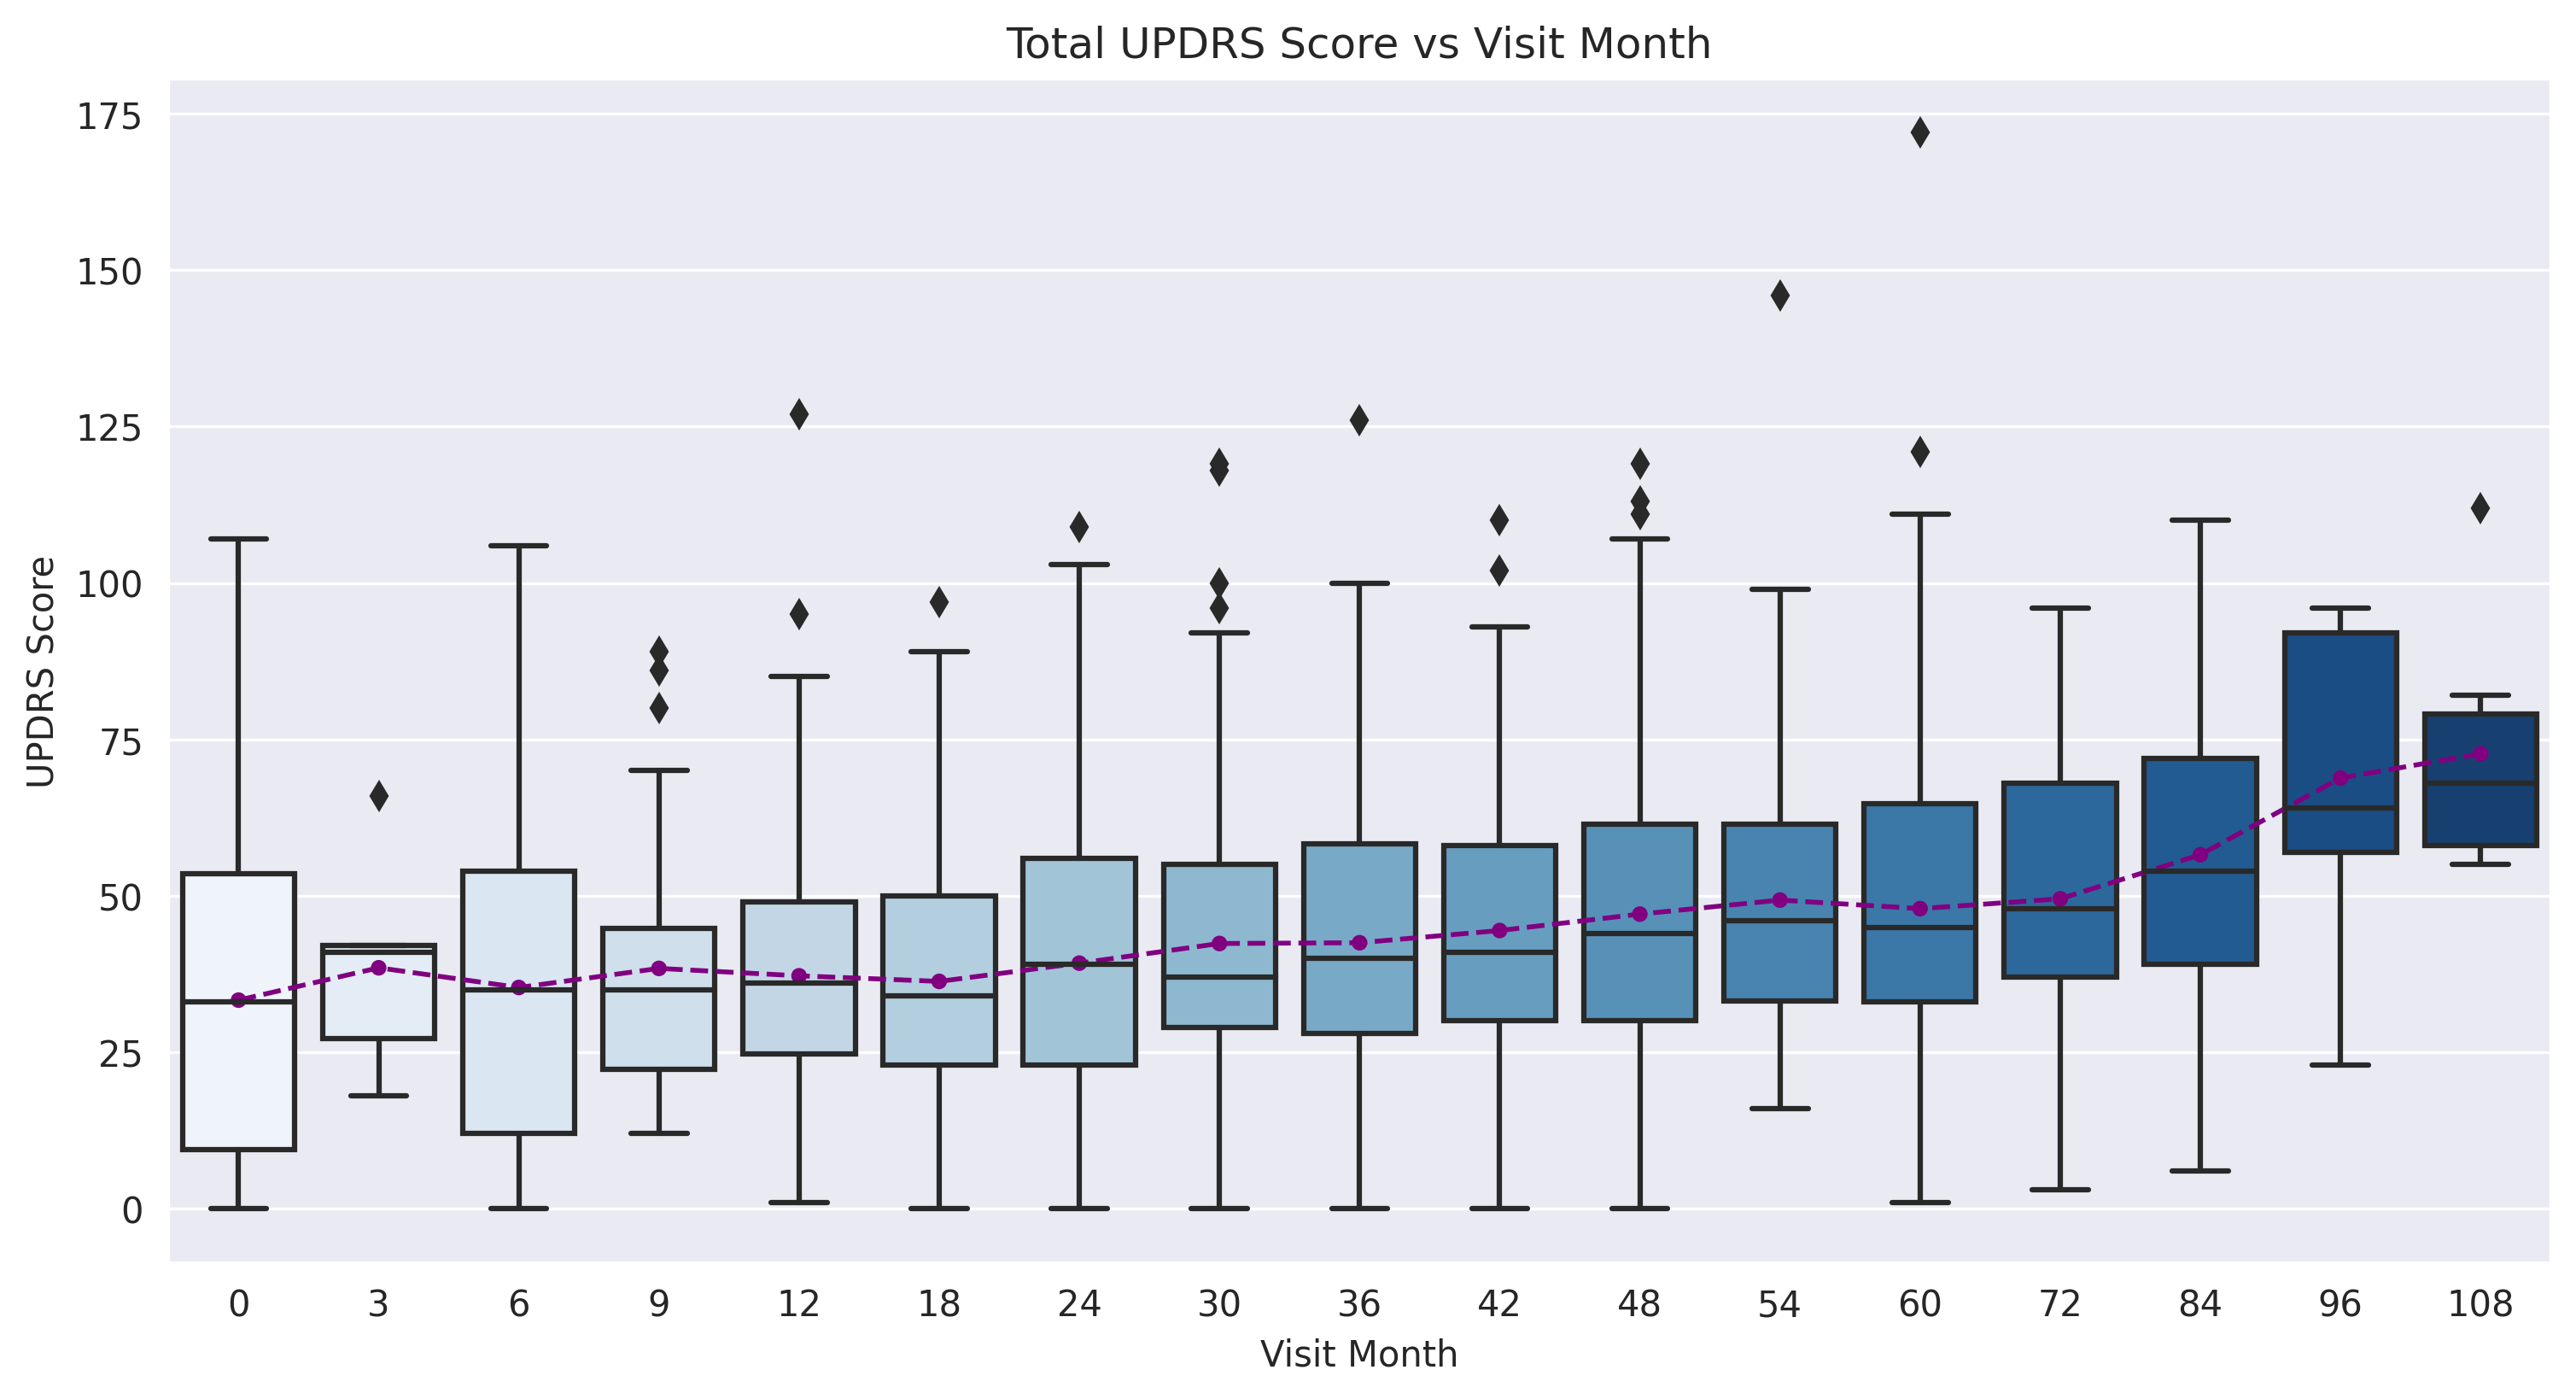

In [22]:
figure, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 6), dpi=300)


# Iterate through each unique column in the clinical_data_df DataFrame

data = clinical_data_df.copy()
data["updrs_total"] = data["updrs_1"] + data["updrs_2"] + data["updrs_3"] + data["updrs_4"]

# Create a box plot using Seaborn
sns.boxplot(x="visit_month", y="updrs_total", data=data, ax=axes, palette="Blues")
sns.pointplot(x="visit_month", y="updrs_total", data=data, ax=axes, color="purple", errorbar=None, linestyles="--", scale=.5)

# Set plot title and axis labels
axes.set_title(f"Total UPDRS Score vs Visit Month")
axes.set_xlabel("Visit Month")
axes.set_ylabel("UPDRS Score")


Examining the plots in this section does not reveal any sigificant trends other than the UPDRS scores for each patient seem to increase with each visit. This is expected as `visit_month` has a weak positive correlation with all of the `updrs` columns and the disease progresses with time, the UPDRS scores will increase.  

This tells us that we cannot rely on the `visit_month` column as a feature to reliably predict the `updrs` values for each patient.

### 2.2.4 Exploring relation between Clinical and Protein data

In [23]:
def log_transform_values(df, column_name):
    """Transform NPX or PeptideAbundance values to log scale."""
    # Create a copy of the DataFrame
    df = df.copy()

    # Apply log transformation, +1 to avoid taking log of 0
    df[column_name] = np.log1p(df[column_name])

    return df


In [24]:
# transforming the NPX values to log scale
proteins_df = log_transform_values(proteins_df, "NPX")
print("Log Transformed NPX values:")
display(proteins_df)

# Pivot the proteins_df DataFrame to have the `UniProt` values as columns
proteins_df = proteins_df.pivot_table(
    index=["patient_id", "visit_month"],
    columns="UniProt",
    values="NPX",
)
print("\n\nPivoted DataFrame:")
display(proteins_df)

# Merge the clinical_data_df DataFrame with the proteins_df DataFrame
clinical_protein_df = pd.merge(
    clinical_data_df,
    proteins_df,
    how="left",
    on=["patient_id", "visit_month"],
)
print("\n\nMerged DataFrame:")
display(clinical_protein_df)


Log Transformed NPX values:


visit_month  patient_id UniProt        NPX
0                 0          55  O00391   9.328594
1                 0          55  O00533  13.504124
2                 0          55  O00584  10.586251
3                 0          55  O14498  10.634121
4                 0          55  O14773  10.349423
...             ...         ...     ...        ...
232736          108       58648  Q9UBX5  10.217889
232737          108       58648  Q9UHG2  12.819738
232738          108       58648  Q9UKV8  11.569599
232739          108       58648  Q9Y646   9.964517
232740          108       58648  Q9Y6R7   9.795574

[232741 rows x 4 columns]



Pivoted DataFrame:


UniProt                   O00391     O00533     O00584     O14498     O14773  \
patient_id visit_month                                                         
55         0            9.328594  13.504124  10.586251  10.634121  10.349423   
           6            9.485287  13.354215  10.469420  10.628521  10.174312   
           12           9.632899  13.611046  10.637102  10.590725  10.332168   
           36           9.512798  13.532926  10.670115  10.680622  10.421644   
942        6            9.325426  12.898017   9.932172  10.351115   8.728196   
...                          ...        ...        ...        ...        ...   
64674      84                NaN  12.157344  10.122980   9.827907   9.222852   
65043      0            9.508473  13.740739  10.661076  10.684284   9.907096   
           12           9.556473  13.800044  10.274768  10.655891  10.140865   
           24           9.592912  13.875684  10.745947  10.553049   9.997561   
           48           9.267722  13.712852  10.712010  10.565467   9.912908   

UniProt                   O14791     O15240     O15394     O43505     O60888  \
patient_id visit_month                                                         
55         0            8.343723  12.088280  11.049289  12.717029  12.024856   
           6            8.393311  12.017566  11.044017  12.534779  12.045587   
           12           8.376689  11.925525  11.111912  12.714100  11.926326   
           36           8.588222  11.523440  11.121209  12.668205  11.719151   
942        6            7.849858  11.986217  10.678770  12.016878  11.353621   
...                          ...        ...        ...        ...        ...   
64674      84           7.744877  11.036443  10.283625  11.381609  11.480427   
65043      0            8.095562  12.492529  11.677465  12.854920  12.413347   
           12           8.092135  12.508308  11.592171  12.682127  12.291691   
           24           8.291882  12.307541  11.671680  12.761890  12.078023   
           48           8.051363  12.223362  11.359576  11.987475  12.082707   

UniProt                 ...     Q9HDC9     Q9NQ79     Q9NYU2     Q9UBR2  \
patient_id visit_month  ...                                               
55         0            ...  12.808956  10.478105  11.482534  10.048605   
           6            ...  12.913313  10.320011  11.600707  10.064790   
           12           ...  12.624632  10.669588  11.652009   9.992464   
           36           ...  12.623460  10.782894  11.606370  10.082955   
942        6            ...  12.442622  10.219495  11.448896   9.767204   
...                     ...        ...        ...        ...        ...   
64674      84           ...  12.468522   8.873598  11.554816   9.259226   
65043      0            ...  12.135731  10.161952        NaN   9.974957   
           12           ...  12.616008  10.014331  11.567669   9.928268   
           24           ...  12.613003  10.861776  11.844328   9.875613   
           48           ...  12.315541   9.983264  11.665398   9.552106   

UniProt                    Q9UBX5     Q9UHG2     Q9UKV8     Q9UNU6     Q9Y646  \
patient_id visit_month                                                          
55         0            11.017212  12.920734        NaN  10.300914  10.078898   
           6            10.852377  12.820910        NaN  10.040472   9.782647   
           12           11.028404  12.671547  11.093822  10.281732  10.258960   
           36           11.159453  12.841461  11.224938  10.365131  10.007284   
942        6             9.966467  12.633371  11.318570  10.086630   9.849058   
...                           ...        ...        ...        ...        ...   
64674      84            9.996304  11.825734  11.038408        NaN   9.238801   
65043      0            10.957190  12.938784  10.534376        NaN  10.252294   
           12           10.896965  12.848119  10.611275        NaN   9.743125   
           24           11.106023  12.614696  10.49



Merged DataFrame:


patient_id  visit_month  updrs_1  updrs_2  updrs_3  updrs_4  \
0             55            0     10.0      6.0     15.0      NaN   
1             55            3     10.0      7.0     25.0      NaN   
2             55            6      8.0     10.0     34.0      NaN   
3             55            9      8.0      9.0     30.0      0.0   
4             55           12     10.0     10.0     41.0      0.0   
...          ...          ...      ...      ...      ...      ...   
2610       65043           48      7.0      6.0     13.0      0.0   
2611       65043           54      4.0      8.0     11.0      1.0   
2612       65043           60      6.0      6.0     16.0      1.0   
2613       65043           72      3.0      9.0     14.0      1.0   
2614       65043           84      7.0      9.0     20.0      3.0   

      medication_On  medication_nan    O00391     O00533  ...     Q9HDC9  \
0               0.0             1.0  9.328594  13.504124  ...  12.808956   
1               0.0             1.0       NaN        NaN  ...        NaN   
2               0.0             1.0  9.485287  13.354215  ...  12.913313   
3               1.0             0.0       NaN        NaN  ...        NaN   
4               1.0             0.0  9.632899  13.611046  ...  12.624632   
...             ...             ...       ...        ...  ...        ...   
2610            0.0             0.0  9.267722  13.712852  ...  12.315541   
2611            0.0             0.0       NaN        NaN  ...        NaN   
2612            0.0             0.0       NaN        NaN  ...        NaN   
2613            0.0             0.0       NaN        NaN  ...        NaN   
2614            0.0             0.0       NaN        NaN  ...        NaN   

         Q9NQ79     Q9NYU2     Q9UBR2     Q9UBX5     Q9UHG2     Q9UKV8  \
0     10.478105  11.482534  10.048605  11.017212  12.920734        NaN   
1           NaN        NaN        NaN        NaN        NaN        NaN   
2     10.320011  11.600707  10.064790  10.852377  12.820910        NaN   
3           NaN        NaN        NaN        NaN        NaN        NaN   
4     10.669588  11.652009   9.992464  11.028404  12.671547  11.093822   
...         ...        ...        ...        ...        ...        ...   
2610   9.983264  11.665398   9.552106  10.795432  12.678642  10.572539   
2611        NaN        NaN        NaN        NaN        NaN        NaN   
2612        NaN        NaN        NaN        NaN        NaN        NaN   
2613        NaN        NaN        NaN        NaN        NaN        NaN   
2614        NaN        NaN        NaN        NaN        NaN        NaN   

         Q9UNU6     Q9Y646     Q9Y6R7  
0     10.300914  10.078898   9.849797  
1           NaN        NaN        NaN  
2     10.040472   9.782647   9.719787  
3           NaN        NaN        NaN  
4     10.281732  10.258960   9.867441  
...         ...        ...        ...  
2610        NaN   9.913428  10.584967  
2611        NaN        NaN        NaN  
2612        NaN        NaN        NaN  
2613        NaN        NaN        NaN  
2614        NaN        NaN        NaN  

[2615 rows x 235 columns]

In [25]:
# clinical_protein_df_corr = clinical_protein_df.corr(method="spearman")


# rows_per_heatmap = 4
# cols_per_heatmap = 24


# # Calculate the number of heatmaps needed
# n_heatmaps = np.ceil(227 / cols_per_heatmap)


# figure, axes = plt.subplots(nrows=int(n_heatmaps), ncols=1, figsize=(20, 40))

# # Create a loop to generate all the heatmaps
# for heatmap_index in range(int(n_heatmaps)):

#     start_col = 8 + heatmap_index * cols_per_heatmap
#     end_col = min((heatmap_index + 1) * cols_per_heatmap + 7, 227)

    
#     sns.heatmap(
#         clinical_protein_df_corr.iloc[0:4, start_col:end_col],
#         annot=True,
#         # cbar=False,
#         ax=axes[heatmap_index],
#         cmap=sns.diverging_palette(230, 20, as_cmap=True).reversed(),
#         square=True,
#         linewidths=.1
#     )

#     # axes[heatmap_index].set_title("Clinical Data Correlation with Proteins (NPX) values")
#     axes[heatmap_index].set_xticklabels(axes[heatmap_index].get_xticklabels(), rotation=90)
#     axes[heatmap_index].set_yticklabels(axes[heatmap_index].get_yticklabels(), rotation=0)

# axes[0].set_title("Clinical Data Correlation with Proteins (NPX) values", fontsize=20)
# figure.tight_layout()





While each of the UPDRS scores seem to have some correlation with the NPX values of multiple proteins, the correlation is not very strong.

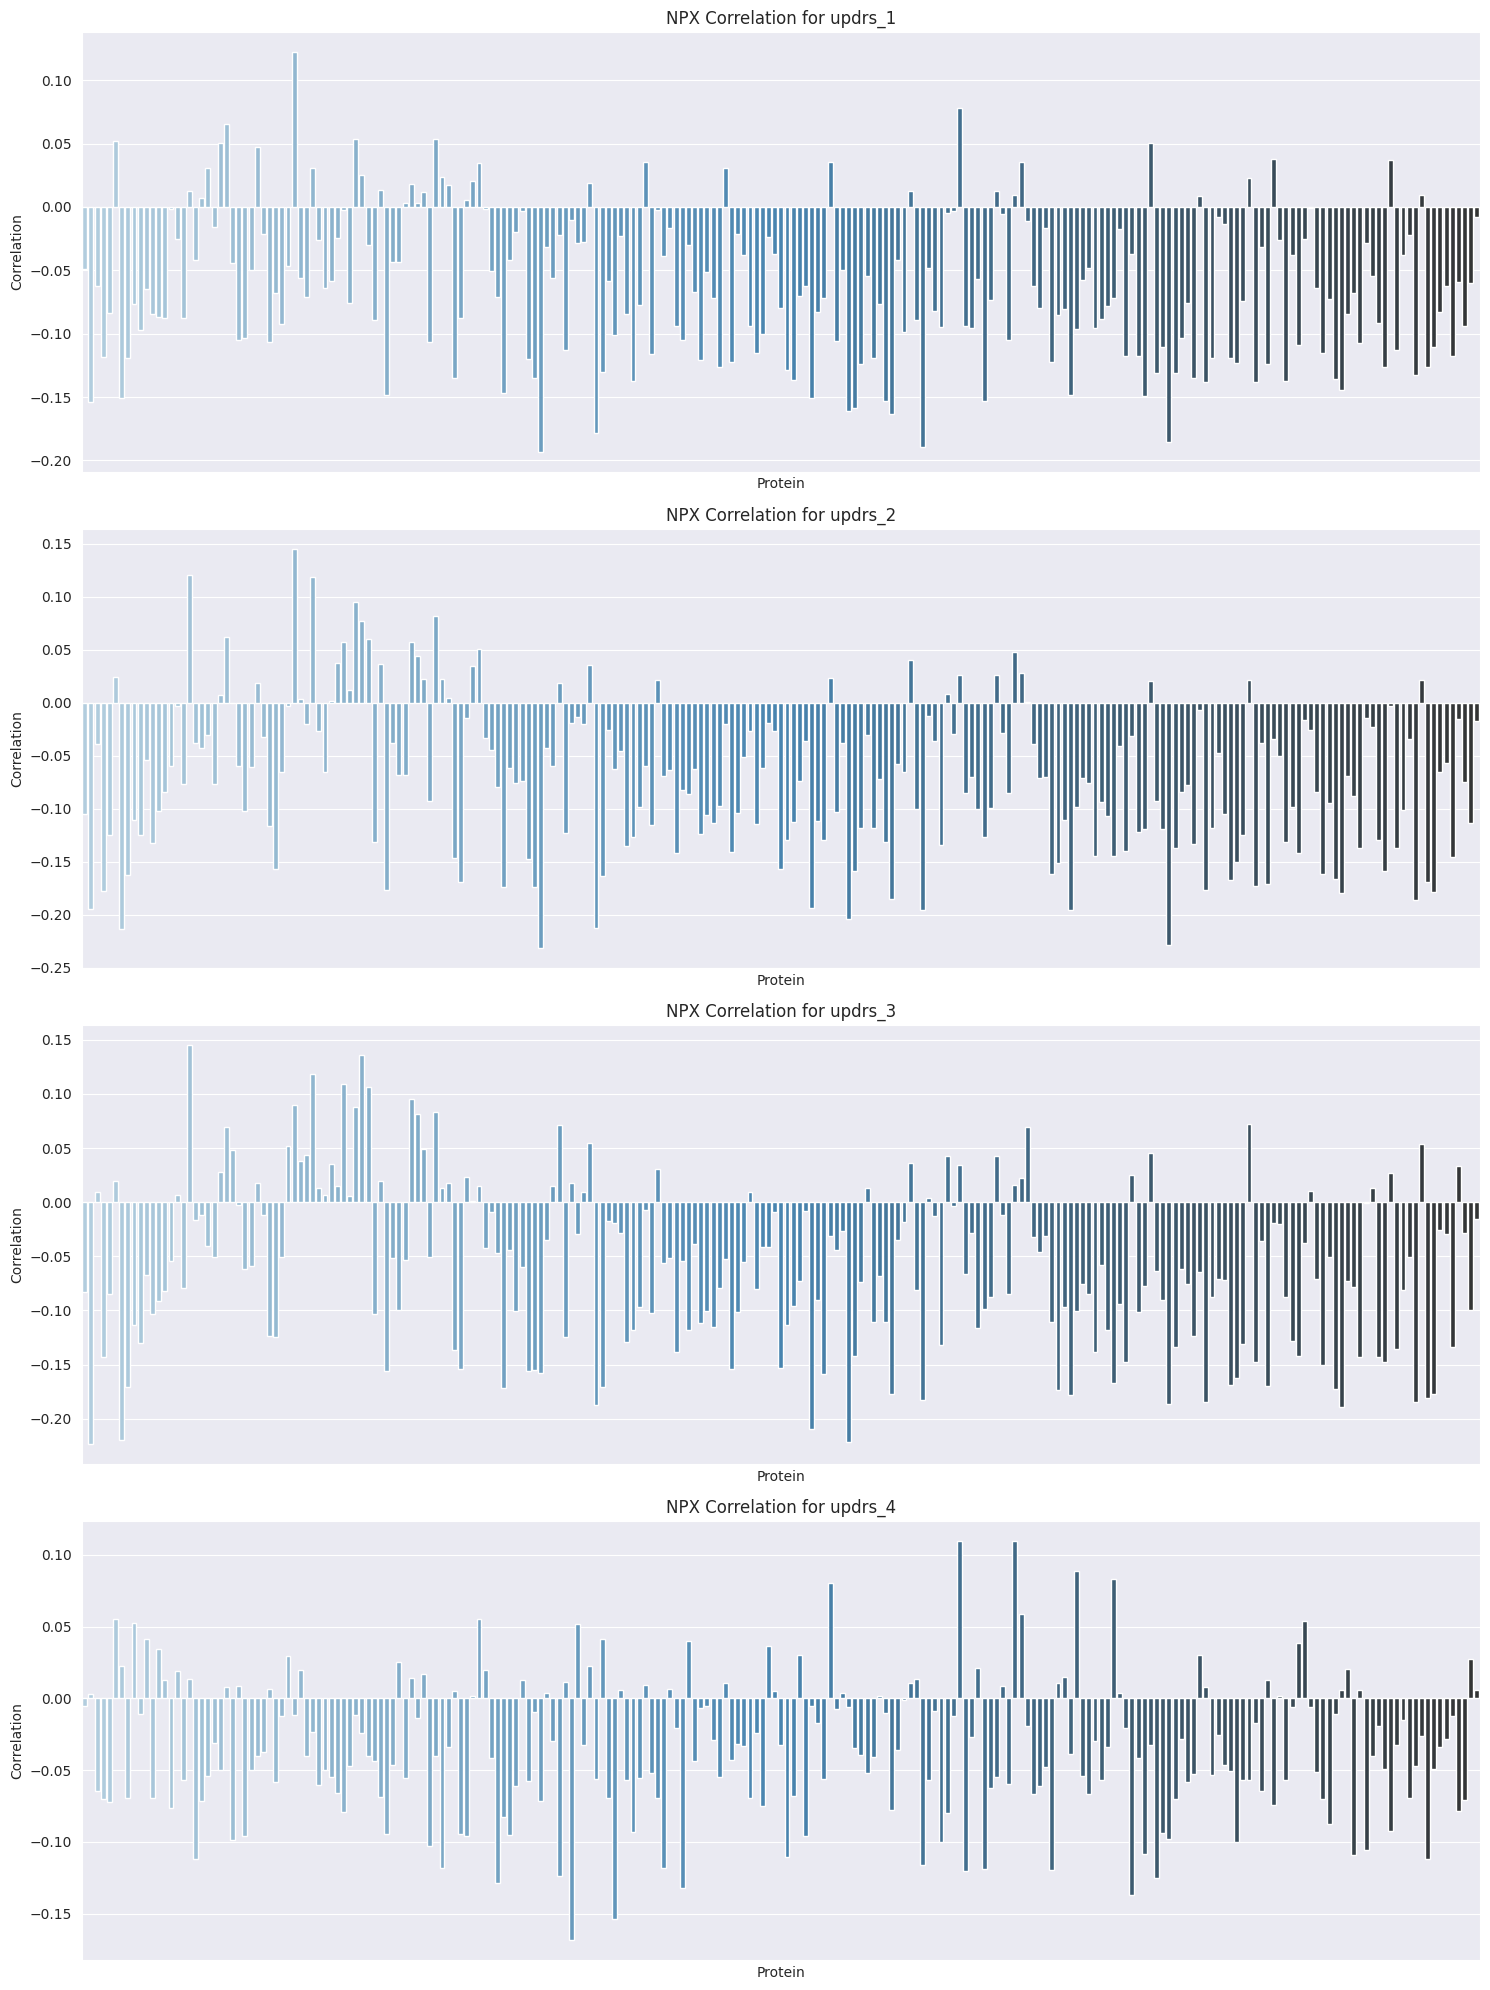

In [26]:
clinical_protein_df_corr = clinical_protein_df.corr(method="spearman")


# Create a bar plot using Seaborn
figure, axes = plt.subplots(nrows=4, ncols=1, figsize=(15, 20))

for index in range(2, 6):

    ax = axes[index - 2]

    data = clinical_protein_df_corr.iloc[index, 8:].reset_index().rename(columns={'index': 'Protein', f'updrs_{index-1}': 'Value'})
    sns.barplot(x='Protein', y='Value', data=data, ax=ax, palette="Blues_d")

    # Set plot title and axis labels
    ax.set_title(f'NPX Correlation for updrs_{index-1}')
    ax.set_xlabel('Protein')
    ax.set_ylabel('Correlation')


    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.set_xticks([])

# Show the plot
figure.tight_layout()
plt.show()

### 2.2.5 Exploring relation between Clinical and Peptide data

#### 2.2.5.1 Merging `train_clinical_data.csv`, `train_protein.csv` and `train_peptides.csv` dataframes

In [27]:
# Create a new column combining the 'UniProt' and 'Peptide' information
peptides_df["UniProt_Peptide"] = peptides_df["UniProt"] + "_" + peptides_df["Peptide"]
print("Combined UniProt and Peptide information:")
display(peptides_df)

# converting the PeptideAbundance values to log scale
peptides_df = log_transform_values(peptides_df, "PeptideAbundance")
print("\n\nLog Transformed PeptideAbundance values:")
display(peptides_df)


# Pivot the peptides_df DataFrame to have the `UniProt_Peptide` values as columns
peptides_df = peptides_df.pivot_table(
    index=["patient_id", "visit_month"],
    columns="UniProt_Peptide",
    values="PeptideAbundance"
)
print("\n\nPivoted DataFrame:")
display(peptides_df)

# Merge the clinical_data_df and protein_df DataFrame with the peptides_df DataFrame
clinical_protein_peptide_df = pd.merge(
    clinical_protein_df,
    peptides_df,
    how="left",
    on=["patient_id", "visit_month"],
)
print("\n\nMerged DataFrame:")
display(clinical_protein_peptide_df)


Combined UniProt and Peptide information:


visit_month  patient_id UniProt  \
0                 0          55  O00391   
1                 0          55  O00533   
2                 0          55  O00533   
3                 0          55  O00533   
4                 0          55  O00533   
...             ...         ...     ...   
981829          108       58648  Q9UHG2   
981830          108       58648  Q9UKV8   
981831          108       58648  Q9Y646   
981832          108       58648  Q9Y6R7   
981833          108       58648  Q9Y6R7   

                                       Peptide  PeptideAbundance  \
0                                NEQEQPLGQWHLS          11254.30   
1                                  GNPEPTFSWTK         102060.00   
2                              IEIPSSVQQVPTIIK         174185.00   
3       KPQSAVYSTGSNGILLC(UniMod_4)EAEGEPQPTIK          27278.90   
4                                 SMEQNGPGLEYR          30838.70   
...                                        ...               ...   
981829                         ILAGSADSEGVAAPR         202820.00   
981830                           SGNIPAGTTVDTK         105830.00   
981831                             LALLVDTVGPR          21257.60   
981832        AGC(UniMod_4)VAESTAVC(UniMod_4)R           5127.26   
981833                          GATTSPGVYELSSR          12825.90   

                                      UniProt_Peptide  
0                                O00391_NEQEQPLGQWHLS  
1                                  O00533_GNPEPTFSWTK  
2                              O00533_IEIPSSVQQVPTIIK  
3       O00533_KPQSAVYSTGSNGILLC(UniMod_4)EAEGEPQPTIK  
4                                 O00533_SMEQNGPGLEYR  
...                                               ...  
981829                         Q9UHG2_ILAGSADSEGVAAPR  
981830                           Q9UKV8_SGNIPAGTTVDTK  
981831                             Q9Y646_LALLVDTVGPR  
981832        Q9Y6R7_AGC(UniMod_4)VAESTAVC(UniMod_4)R  
981833                          Q9Y6R7_GATTSPGVYELSSR  

[981834 rows x 6 columns]



Log Transformed PeptideAbundance values:


visit_month  patient_id UniProt  \
0                 0          55  O00391   
1                 0          55  O00533   
2                 0          55  O00533   
3                 0          55  O00533   
4                 0          55  O00533   
...             ...         ...     ...   
981829          108       58648  Q9UHG2   
981830          108       58648  Q9UKV8   
981831          108       58648  Q9Y646   
981832          108       58648  Q9Y6R7   
981833          108       58648  Q9Y6R7   

                                       Peptide  PeptideAbundance  \
0                                NEQEQPLGQWHLS          9.328594   
1                                  GNPEPTFSWTK         11.533326   
2                              IEIPSSVQQVPTIIK         12.067879   
3       KPQSAVYSTGSNGILLC(UniMod_4)EAEGEPQPTIK         10.213905   
4                                 SMEQNGPGLEYR         10.336558   
...                                        ...               ...   
981829                         ILAGSADSEGVAAPR         12.220079   
981830                           SGNIPAGTTVDTK         11.569599   
981831                             LALLVDTVGPR          9.964517   
981832        AGC(UniMod_4)VAESTAVC(UniMod_4)R          8.542522   
981833                          GATTSPGVYELSSR          9.459300   

                                      UniProt_Peptide  
0                                O00391_NEQEQPLGQWHLS  
1                                  O00533_GNPEPTFSWTK  
2                              O00533_IEIPSSVQQVPTIIK  
3       O00533_KPQSAVYSTGSNGILLC(UniMod_4)EAEGEPQPTIK  
4                                 O00533_SMEQNGPGLEYR  
...                                               ...  
981829                         Q9UHG2_ILAGSADSEGVAAPR  
981830                           Q9UKV8_SGNIPAGTTVDTK  
981831                             Q9Y646_LALLVDTVGPR  
981832        Q9Y6R7_AGC(UniMod_4)VAESTAVC(UniMod_4)R  
981833                          Q9Y6R7_GATTSPGVYELSSR  

[981834 rows x 6 columns]



Pivoted DataFrame:


UniProt_Peptide         O00391_NEQEQPLGQWHLS  O00533_GNPEPTFSWTK  \
patient_id visit_month                                             
55         0                        9.328594           11.533326   
           6                        9.485287           11.414696   
           12                       9.632899           11.647754   
           36                       9.512798           11.702760   
942        6                        9.325426           10.696218   
...                                      ...                 ...   
64674      84                            NaN           10.443792   
65043      0                        9.508473           11.975262   
           12                       9.556473           11.748598   
           24                       9.592912           11.980902   
           48                       9.267722           11.710661   

UniProt_Peptide         O00533_IEIPSSVQQVPTIIK  \
patient_id visit_month                           
55         0                         12.067879   
           6                         11.901143   
           12                        12.179980   
           36                        11.995166   
942        6                         11.573983   
...                                        ...   
64674      84                        11.302244   
65043      0                               NaN   
           12                        12.598155   
           24                        12.599907   
           48                        12.462806   

UniProt_Peptide         O00533_KPQSAVYSTGSNGILLC(UniMod_4)EAEGEPQPTIK  \
patient_id visit_month                                                  
55         0                                                10.213905   
           6                                                10.099120   
           12                                               10.436800   
           36                                               10.163457   
942        6                                                 9.741833   
...                                                               ...   
64674      84                                                9.352604   
65043      0                                                10.843208   
           12                                               10.706070   
           24                                               10.944619   
           48                                               10.570612   

UniProt_Peptide         O00533_SMEQNGPGLEYR  O00533_TLKIENVSYQDKGNYR  \
patient_id visit_month                                                 
55         0                      10.336558                10.052662   
           6                      10.147762                 9.993584   
           12                     10.313658                10.293148   
           36                     10.541370                10.205808   
942        6                       9.652015                 9.631685   
...                                     ...                      ...   
64674      84                      9.321175                 9.194934   
65043      0                      10.927904                10.881075   
           12                     10.692247                10.537315   
           24                     10.731336                10.681068   
           48                     10.614173                10.366146   

UniProt_Peptide         O00533_VIAVNEVGR  O00533_VMTPAVYAPYDVK  \
patient_id visit_month                                           
55         0                   12.048711             11.910170   
           6                   11.937611             11.686736   
           12                  12.127332             12.058692   
           36                  12.009979             12.023975   
942        6                   11.257272             11.459877   
...                                  ...                   ...   
64674      84                  10.659879         



Merged DataFrame:


patient_id  visit_month  updrs_1  updrs_2  updrs_3  updrs_4  \
0             55            0     10.0      6.0     15.0      NaN   
1             55            3     10.0      7.0     25.0      NaN   
2             55            6      8.0     10.0     34.0      NaN   
3             55            9      8.0      9.0     30.0      0.0   
4             55           12     10.0     10.0     41.0      0.0   
...          ...          ...      ...      ...      ...      ...   
2610       65043           48      7.0      6.0     13.0      0.0   
2611       65043           54      4.0      8.0     11.0      1.0   
2612       65043           60      6.0      6.0     16.0      1.0   
2613       65043           72      3.0      9.0     14.0      1.0   
2614       65043           84      7.0      9.0     20.0      3.0   

      medication_On  medication_nan    O00391     O00533  ...  \
0               0.0             1.0  9.328594  13.504124  ...   
1               0.0             1.0       NaN        NaN  ...   
2               0.0             1.0  9.485287  13.354215  ...   
3               1.0             0.0       NaN        NaN  ...   
4               1.0             0.0  9.632899  13.611046  ...   
...             ...             ...       ...        ...  ...   
2610            0.0             0.0  9.267722  13.712852  ...   
2611            0.0             0.0       NaN        NaN  ...   
2612            0.0             0.0       NaN        NaN  ...   
2613            0.0             0.0       NaN        NaN  ...   
2614            0.0             0.0       NaN        NaN  ...   

      Q9UBX5_DQPFTILYR  Q9UHG2_AEAQEAEDQQAR  Q9UHG2_ARAEAQEAEDQQAR  \
0            10.853766             9.157238              11.312526   
1                  NaN                  NaN                    NaN   
2            10.696021             9.241539              11.226911   
3                  NaN                  NaN                    NaN   
4            10.875056             8.873458              11.020074   
...                ...                  ...                    ...   
2610         10.637901             8.703721              10.928550   
2611               NaN                  NaN                    NaN   
2612               NaN                  NaN                    NaN   
2613               NaN                  NaN                    NaN   
2614               NaN                  NaN                    NaN   

      Q9UHG2_GEAAGAVQELAR  Q9UHG2_ILAGSADSEGVAAPR  Q9UKV8_SGNIPAGTTVDTK  \
0               11.499387               12.295566                   NaN   
1                     NaN                     NaN                   NaN   
2               11.348140               12.204191                   NaN   
3                     NaN                     NaN                   NaN   
4               11.311607               12.035071             11.093822   
...                   ...                     ...                   ...   
2610            11.204873               12.131171             10.572539   
2611                  NaN                     NaN                   NaN   
2612                  NaN                     NaN                   NaN   
2613                  NaN                     NaN                   NaN   
2614                  NaN                     NaN                   NaN   

      Q9UNU6_KNM(UniMod_35)FEFLK  Q9Y646_LALLVDTVGPR  \
0                      10.300914           10.078898   
1                            NaN                 NaN   
2                      10.040472            9.782647   
3                            NaN                 NaN   
4                      10.281732           10.258960   
...                          ...                 ...   
2610                         NaN            9.913428   
2611                         NaN                 NaN   
2612                         NaN                 NaN   
2613                         NaN                 NaN   
2614                         NaN      

In [28]:
clinical_protein_peptide_df_corr = clinical_protein_peptide_df.corr(method="spearman")


# Create a bar plot using Seaborn
figure, axes = plt.subplots(nrows=4, ncols=1, figsize=(30, 20), dpi=600)

for index in range(2, 6):

    ax = axes[index - 2]

    data = clinical_protein_peptide_df_corr.iloc[index, 235:].reset_index().rename(columns={'index': 'Peptide', f'updrs_{index-1}': 'Value'})
    sns.barplot(x='Peptide', y='Value', data=data, ax=ax, palette="Blues_d")

    # Set plot title and axis labels
    ax.set_title(f'PeptideAbundance Correlation for updrs_{index-1}')
    ax.set_xlabel('Peptide')
    ax.set_ylabel('Correlation')


    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.set_xticks([])

# Show the plot
figure.tight_layout()
plt.show()

Previous two correlation graphs show that none of the UPDRS scores have any strong correlation with the PeptideAbundance values of any of the peptides or NPX values of any of the proteins. This is understandable because the UPDRS scores are more likely to be correlated with multiple proteins and peptides rather than just one protein or peptide.

Due to this reason, it will not be advisable to filter our any of the proteins or peptides manually. Instead, we will have to use some other feature reduction or dimensionality reduction technique to reduce the number of features if required.

### 2.2.6 Other interesting observations

In [29]:
clinical_protein_peptide_df

patient_id  visit_month  updrs_1  updrs_2  updrs_3  updrs_4  \
0             55            0     10.0      6.0     15.0      NaN   
1             55            3     10.0      7.0     25.0      NaN   
2             55            6      8.0     10.0     34.0      NaN   
3             55            9      8.0      9.0     30.0      0.0   
4             55           12     10.0     10.0     41.0      0.0   
...          ...          ...      ...      ...      ...      ...   
2610       65043           48      7.0      6.0     13.0      0.0   
2611       65043           54      4.0      8.0     11.0      1.0   
2612       65043           60      6.0      6.0     16.0      1.0   
2613       65043           72      3.0      9.0     14.0      1.0   
2614       65043           84      7.0      9.0     20.0      3.0   

      medication_On  medication_nan    O00391     O00533  ...  \
0               0.0             1.0  9.328594  13.504124  ...   
1               0.0             1.0       NaN        NaN  ...   
2               0.0             1.0  9.485287  13.354215  ...   
3               1.0             0.0       NaN        NaN  ...   
4               1.0             0.0  9.632899  13.611046  ...   
...             ...             ...       ...        ...  ...   
2610            0.0             0.0  9.267722  13.712852  ...   
2611            0.0             0.0       NaN        NaN  ...   
2612            0.0             0.0       NaN        NaN  ...   
2613            0.0             0.0       NaN        NaN  ...   
2614            0.0             0.0       NaN        NaN  ...   

      Q9UBX5_DQPFTILYR  Q9UHG2_AEAQEAEDQQAR  Q9UHG2_ARAEAQEAEDQQAR  \
0            10.853766             9.157238              11.312526   
1                  NaN                  NaN                    NaN   
2            10.696021             9.241539              11.226911   
3                  NaN                  NaN                    NaN   
4            10.875056             8.873458              11.020074   
...                ...                  ...                    ...   
2610         10.637901             8.703721              10.928550   
2611               NaN                  NaN                    NaN   
2612               NaN                  NaN                    NaN   
2613               NaN                  NaN                    NaN   
2614               NaN                  NaN                    NaN   

      Q9UHG2_GEAAGAVQELAR  Q9UHG2_ILAGSADSEGVAAPR  Q9UKV8_SGNIPAGTTVDTK  \
0               11.499387               12.295566                   NaN   
1                     NaN                     NaN                   NaN   
2               11.348140               12.204191                   NaN   
3                     NaN                     NaN                   NaN   
4               11.311607               12.035071             11.093822   
...                   ...                     ...                   ...   
2610            11.204873               12.131171             10.572539   
2611                  NaN                     NaN                   NaN   
2612                  NaN                     NaN                   NaN   
2613                  NaN                     NaN                   NaN   
2614                  NaN                     NaN                   NaN   

      Q9UNU6_KNM(UniMod_35)FEFLK  Q9Y646_LALLVDTVGPR  \
0                      10.300914           10.078898   
1                            NaN                 NaN   
2                      10.040472            9.782647   
3                            NaN                 NaN   
4                      10.281732           10.258960   
...                          ...                 ...   
2610                         NaN            9.913428   
2611                         NaN                 NaN   
2612                         NaN                 NaN   
2613                         NaN                 NaN   
2614                         NaN      

In [30]:
visits_with_missing_protein_peptide_info = clinical_protein_peptide_df.iloc[:, 8:].isnull().all(axis=1).sum()
print(f"Number of visits with missing protein and peptide information: {visits_with_missing_protein_peptide_info}")
print(f"Percentage of visits with missing protein and peptide information: {visits_with_missing_protein_peptide_info / clinical_protein_peptide_df.shape[0] * 100:.2f}%")

Number of visits with missing protein and peptide information: 1547
Percentage of visits with missing protein and peptide information: 59.16%


In [31]:
visits_with_missing_medication_info = clinical_protein_peptide_df["medication_nan"].sum()
print(f"Number of visits with missing medication information: {visits_with_missing_medication_info}")
print(f"Percentage of visits with missing medication information: {visits_with_missing_medication_info / clinical_protein_peptide_df.shape[0] * 100:.2f}%")

Number of visits with missing medication information: 1327.0
Percentage of visits with missing medication information: 50.75%


The above result tells us that majority of the patient visits do not have any medication or protein/peptide data. The missing medication information also explains why `medication_nan` had a high negative correlation with most of the `updrs` values in [Section 2.2.1 Correlation between columns in `train_clinical_data.csv`](#2.2.1-Correlation-between-columns-in-`train_clinical_data.csv`).


All this tells us that our models should be robust to missing values. This rules out most of our usual models like `LinearRegression`, etc. and leaves us with tree-based regression models like `RandomForestRegressor`, `AdaBoostRegressor`, `XGBoostRegressor`, etc. which are robust to missing values.


On a side note: All of the `updrs` columns have some missing values. However, it is imperitive that we do not impute these missing values because the `updrs` values are collected from the patients and imputing these values will lead to certain bias in our model incorrect predictions. 

This is because, when a `updrs` value is missing, it means that the particular part of test was not conducted on the patient. We also cannot impute the missing values with 0 because when a `updrs` value is 0, it means that the particular part of test was conducted on the patient and the patient did not have any symptoms of parkinson's disease. So, our best sceanerio will just be to drop the rows with missing `updrs` values. 

With that said, it can also be argued that certain advanced techniques can be used to impute the missing values. For example, we can train a model or use something like `KNNImputer` to predict the missing `updrs` values based on the patient's previous updrs values or a combination of other factors.  
However, this is beyond the scope of this project.

## 3. Data Processing


### 3.1 Creating Test and Train Datasets

In [32]:
# Creating train test split based on patient_id

# Note: This decision was made based on the following Kaggle discussion: 
#[Link](https://www.kaggle.com/competitions/amp-parkinsons-disease-progression-prediction/discussion/403045), 
# which suggests that the test set does not contains patients from the training data.

# Set the seed for reproducibility
np.random.seed(42)

# Define the train, and test split ratios
train_ratio = .8
test_ratio = .2

# Extract unique patient_id values
patient_ids = clinical_protein_peptide_df['patient_id'].unique()

# Shuffle the patient_ids
np.random.shuffle(patient_ids)

# Split the patient_ids into train, and test sets
total = len(patient_ids)
train_size = int(train_ratio * total)


train_ids = patient_ids[:train_size]
test_ids = patient_ids[train_size:]

# Select the data corresponding to each set of patient_ids
train_data = clinical_protein_peptide_df[clinical_protein_peptide_df["patient_id"].isin(train_ids)]
test_data = clinical_protein_peptide_df[clinical_protein_peptide_df["patient_id"].isin(test_ids)]

print("Train data Shape:", train_data.shape)
print("Test data Shape:", test_data.shape)
print()
print("Train data patient_id unique count:", train_data["patient_id"].nunique())
print("Test data patient_id unique count:", test_data["patient_id"].nunique())

Train data Shape: (2071, 1203)
Test data Shape: (544, 1203)

Train data patient_id unique count: 198
Test data patient_id unique count: 50


### 3.2 Expand dataset with visit_month_offset rows.

In [33]:
# Add visit_month_offset column to the data. The competition requires us to predict 
# the updrs values for 6, 12, and 24 months after the last visit_month.
# 
# We have 4 updrs values. However, most of the Tree-based models can only predict one value at a time.
# Therefore, we will create 3 new rows for each visit_month, and each row will contain the updrs value for
# 6, 12, and 24 months after the visit_month.
#
# In easier terms the `processs_data` does the following:
#
#   1.  terates through the input data DataFrame and constructs a nested dictionary 
#       data_dict with patient IDs as the first level keys, and visit months as the
#       second level keys. The values of the inner dictionary are the rows of the 
#       DataFrame corresponding to the patient ID and visit month.
#
#   2.  Adds a new column visit_month_offset to the input DataFrame data and 
#       initializes it with zeros.
# 
#   3.  Iterates through the input DataFrame data again, and for each row, checks 
#       if there are rows for the same patient ID in the data_dict dictionary with 
#       a visit month that is 6, 12, or 24 months ahead of the current row's visit month. 
#       If such a row exists, it creates a new row with the same values but updates the 
#       visit_month and visit_month_offset columns to the original visit month and the 
#       month offset (6, 12, or 24) respectively, and appends the new row to the new_rows 
#       list.
#
#   4.  Creates a new DataFrame new_df by concatenating the rows in the new_rows list 
#       along the columns (axis=1) and transposing the resulting DataFrame.
# 
#   5.  Finally, concatenates the input DataFrame data and the newly created new_df
#       along the rows (axis=0) to form the final processed DataFrame processed_data
#       and returns it.

def process_data(data):
    data = data.copy()
    data_dict = {}

    # Step 1:
    for index, row in data.iterrows():
        patient_id = row["patient_id"]
        visit_month = row["visit_month"]
        if patient_id not in data_dict:
            data_dict[patient_id] = {}
        data_dict[patient_id][visit_month] = row

    # Step 2:
    data.loc[:, "visit_month_offset"] = 0

    # Step 3:
    new_rows = []

    for index, row in data.iterrows():
        patient_id = row["patient_id"]
        visit_month = row["visit_month"]

        for month_offset in [6, 12, 24]:
            new_visit_month = visit_month + month_offset

            if new_visit_month in data_dict[patient_id]:
                new_row = data_dict[patient_id][new_visit_month].copy()
                new_row["visit_month"] = visit_month
                new_row["visit_month_offset"] = month_offset
                new_rows.append(new_row)

    # Step 4:
    new_df = pd.concat(new_rows, axis=1).T

    # Step 5:
    processed_data = pd.concat([data, new_df], axis=0)

    return processed_data


# Assuming train_data, val_data, and test_data are your dataframes
train_data = process_data(train_data)
test_data = process_data(test_data)


### 3.3 Add lag values of updrs columns as features

In [34]:
# This function adds the lagged updrs features to the input DataFrame df.
# For example:

#   1.  If the input DataFrame df contains the following columns:

#           patient_id  visit_month  updrs_1  updrs_2  updrs_3  updrs_4
#                    1           0         1        2        3        4
#                    1           3         5        6        7        8
#                    1           6         9       10       11       12

#   2.  Add unique visit months found in df [0, 3, 6, 9, 12, 15, 18, 21, 24]:

#   3.  For example, if unique visit months are [0, 3, 6], The function will extend the df as follows:
#
#       patient_id  visit_month  updrs_1  updrs_2  updrs_3  updrs_4 updrs_1_0  updrs_2_0  updrs_3_0  updrs_4_0  updrs_1_3  updrs_2_3  updrs_3_3  updrs_4_3
#                1            0        1        2        3        4       NaN        NaN        NaN        NaN       NaN        NaN        NaN        NaN
#                1            3        5        6        7        8         1          2          3          4       NaN        NaN        NaN        NaN
#                1            6        9       10       11       12         1          2          3          4         5          6          7          8




def add_lagged_updrs_features(df, unique_visit_months):
    unique_patient_ids = df["patient_id"].unique()
    result_df = pd.DataFrame()

    for patient_id in unique_patient_ids:
        data = df[df.patient_id == patient_id].copy()
        data = data.iloc[:, :6].copy()
        data = data.sort_values(by="visit_month", ascending=True)

        for visit_month in unique_visit_months:
            for updrs in ["updrs_1", "updrs_2", "updrs_3", "updrs_4"]:
                new_col_name = f"{updrs}_{int(visit_month)}"
                if new_col_name not in data.columns:
                    data[new_col_name] = np.NaN

        for index, row in data.iterrows():
            updrs_values = row[["updrs_1", "updrs_2", "updrs_3", "updrs_4"]].values
            visit_month = row["visit_month"]

            data.loc[
                data.index > index, [
                    f"updrs_1_{int(visit_month)}",
                    f"updrs_2_{int(visit_month)}",
                    f"updrs_3_{int(visit_month)}",
                    f"updrs_4_{int(visit_month)}"
                ]
            ] = updrs_values
        
        result_df = pd.concat([result_df, data], ignore_index=True)

    return result_df

# Usage:
# processed_data = add_lagged_updrs_features(clinical_protein_peptide_df, clinical_protein_peptide_df.visit_month.unique())

### 3.4 Define SMAPE metric

In [35]:
# SMAPE (Symmetric Mean Absolute Percentage Error) is a metric used to measure the
# accuracy of a model's predictions, particularly in the context of forecasting problems.
#
# It is a symmetric version of the Mean Absolute Percentage Error (MAPE) 
# metric and is a more direct measure of how far away predictions are from the actual values.
# 
# The competition uses SMAPE + 1, where 1 is added to both the actual and forecast values
# to avoid skewing the results when the actual value is 0.


def symmetric_mape_plus_one(y_true, y_pred):
    y_true = np.array(y_true) + 1
    y_pred = np.array(y_pred) + 1

    assert len(y_true) == len(y_pred), "The length of actual and forecast lists must be equal."

    n = len(y_true)

    errors = np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred)) * 2
    sum_errors = np.sum(errors)

    sampe_plus_one = (100 / n) * sum_errors
    return sampe_plus_one



### 3.5 Post-processing Step

In [36]:
# This function rounds the predictions to the nearest integer using the 
# geometric rounding method.
# 
# This is done because all our `updrs` values are left skewed, and the
# geometric rounding method is known to work well instead of the
# traditional rounding method (which is the arithmetic rounding method).
#
# Reference: https://www.kaggle.com/competitions/amp-parkinsons-disease-progression-prediction/discussion/388549

def geometric_round(y_pred):
    result_array = y_pred

    result_array = np.where(
        result_array < np.sqrt(np.floor(y_pred) * np.ceil(y_pred)), 
        np.floor(y_pred), 
        result_array
    )

    result_array = np.where(
        result_array >= np.sqrt(np.floor(y_pred) * np.ceil(y_pred)),
        np.ceil(y_pred),
        result_array
    )
    return result_array

## 4. Models


### 4.1. Baseline Model

In [37]:
# Create a copy of the dataframes
train_df = train_data.copy(deep=True)
test_df = test_data.copy(deep=True)

# Create a list of the feature columns
feature_cols = ["visit_month"] + train_df.columns[6:].to_list()

# Drop the rows with missing values in the target columns
train_df = train_df.dropna(subset=['updrs_1', 'updrs_2', 'updrs_3', 'updrs_4'])
test_df = test_df.dropna(subset=['updrs_1', 'updrs_2', 'updrs_3', 'updrs_4'])


models = {
    # "RandomForestRegressor": RandomForestRegressor(n_estimators=1000, random_state=42, n_jobs=-1),
    # "AdaBoostRegressor": AdaBoostRegressor(n_estimators=1000, learning_rate=0.01, random_state=42),
    "CatBoostRegressor": CatBoostRegressor(n_estimators=1000, learning_rate=0.01),
    "LGBMRegressor": LGBMRegressor(n_estimators=1000, learning_rate=0.01, num_leaves=32, random_state=42, n_jobs=-1),
    "XGBRegressor": XGBRegressor(n_estimators=1000, learning_rate=0.01, random_state=42, n_jobs=-1),
    "HistGradientBoostingRegressor": HistGradientBoostingRegressor(max_iter=1000, learning_rate=0.01, random_state=42),
}


# Create a function for cross-validation, hyperparameter tuning, and evaluation
def evaluate_models(regressor, X_train, y_train, X_test, y_test, target_col_name):
    
    regressor.fit(X_train, y_train)

    y_pred = regressor.predict(X_test)
    y_pred = geometric_round(y_pred)

    score = symmetric_mape_plus_one(y_test, y_pred)
    print(f"SMAPE for {target_col_name}: {score}")

    return score



scores = {}
for model_name, regressor in models.items():

    print("----------------------------------------------")
    print(f"\n\nEvaluating model: {model_name}")
    # Evaluate models for each target variable and store scores
    all_scores = {}

    for target_col_name in ["updrs_1", "updrs_2", "updrs_3", "updrs_4"]:
        print(f"Evaluating models for target: {target_col_name}")
        model_scores = evaluate_models(
            regressor = regressor,
            X_train = train_df[feature_cols],
            y_train = train_df[target_col_name],
            X_test = test_df[feature_cols],
            y_test = test_df[target_col_name],
            target_col_name = target_col_name
        )
        all_scores[target_col_name] = model_scores
        print("\n")


    print("\nAverage SMAPE:", np.mean(list(all_scores.values())))
    scores[model_name] = np.mean(list(all_scores.values()))


# # Create a dataframe to store the model scores
# model_scores_df = pd.DataFrame(scores.items(), columns=["Model", "SMAPE"])
# sns.barplot(y="SMAPE", x="Model", data=model_scores_df.sort_values(by="SMAPE", ascending=False), palette="crest", errorbar=None, width=0.5)
# plt.title("Model Scores")
# plt.show()


----------------------------------------------


Evaluating model: CatBoostRegressor
Evaluating models for target: updrs_1
0:	learn: 5.9252298	total: 312ms	remaining: 5m 11s
1:	learn: 5.9167757	total: 513ms	remaining: 4m 15s
2:	learn: 5.9081676	total: 714ms	remaining: 3m 57s
3:	learn: 5.8987602	total: 910ms	remaining: 3m 46s
4:	learn: 5.8904036	total: 1.11s	remaining: 3m 41s
5:	learn: 5.8813114	total: 1.31s	remaining: 3m 37s
6:	learn: 5.8735511	total: 1.51s	remaining: 3m 34s
7:	learn: 5.8647631	total: 1.71s	remaining: 3m 32s
8:	learn: 5.8549465	total: 1.92s	remaining: 3m 31s
9:	learn: 5.8455564	total: 2.12s	remaining: 3m 29s
10:	learn: 5.8368784	total: 2.33s	remaining: 3m 29s
11:	learn: 5.8292279	total: 2.54s	remaining: 3m 28s
12:	learn: 5.8202717	total: 2.74s	remaining: 3m 27s
13:	learn: 5.8121724	total: 2.94s	remaining: 3m 27s
14:	learn: 5.8042320	total: 3.14s	remaining: 3m 26s
15:	learn: 5.7962835	total: 3.36s	remaining: 3m 26s
16:	learn: 5.7886202	total: 3.56s	remaining: 3m 25s
17:

In [48]:
model_scores_df = pd.DataFrame(scores.items(), columns=["Model", "SMAPE"])

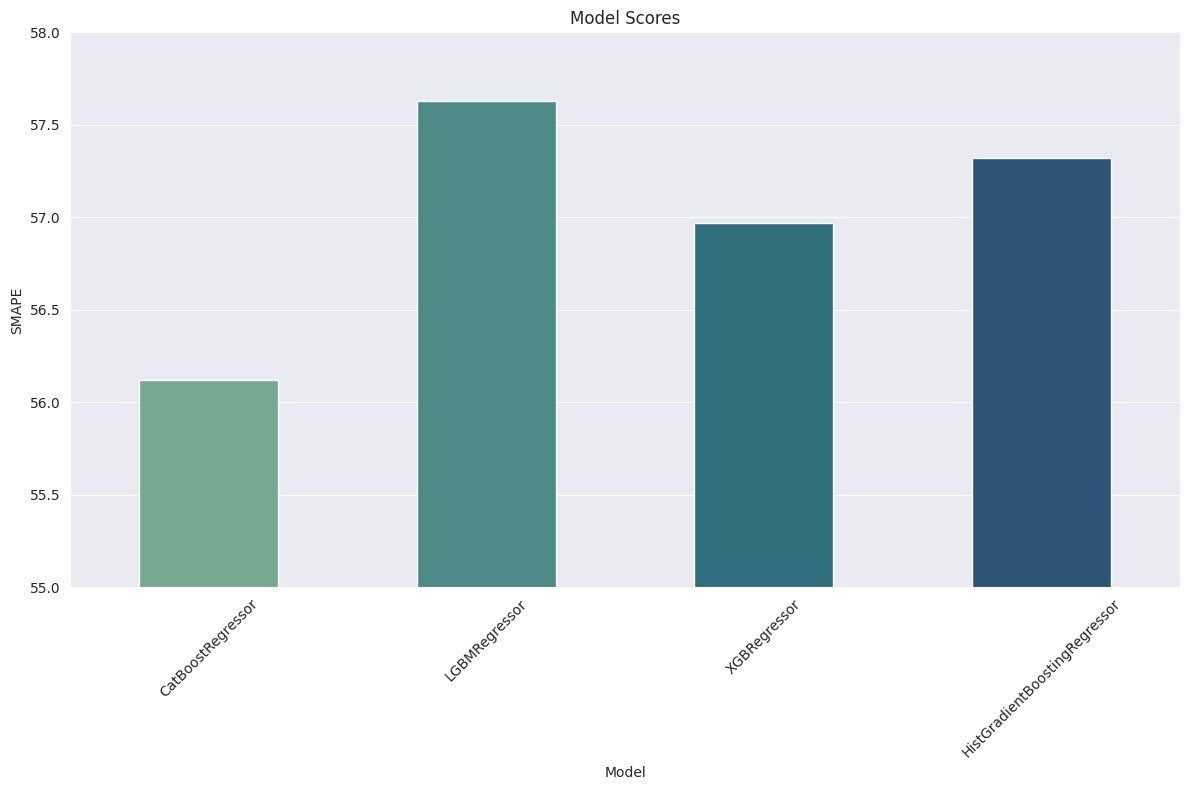

In [51]:
# model_scores_df = pd.DataFrame(scores.items(), columns=["Model", "SMAPE"])
plt.figure(figsize=(12, 8))
ax = sns.barplot(y="SMAPE", x="Model", data=model_scores_df,  palette="crest", errorbar=None, width=0.5)
ax.set_ylim(55, 58)
plt.title("Model Scores")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()